In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aopy
import os
import pandas as pds
from db import dbfunctions as db
from ipywidgets import interactive, widgets
import scipy
import h5py
from tqdm.auto import tqdm 
import seaborn as sn
import sklearn
from sklearn.decomposition import PCA, FactorAnalysis
from itertools import compress
import multiprocessing as mp
import time
import math
import seaborn as sn
from scipy.fft import fft
import glob
from datetime import date

/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


# Set parameters

In [2]:
save_figs = False
# base_save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/"
# np_preproc_data_folder = 'np_analysis_preproc_data'
# ecog_dec_acc_file_name = 'ecog_decoding_maps/npinsert_ecog_decoding_all'
preproc_dir = "/media/moor-data/test/Safaie et al 2023 data/parsed"
# filenames = ['Chewie_CO_20150313_parsed.mat', 'Chewie_CO_20150319_parsed.mat', 'Mihili_CO_20140218_parsed']
filenames = ['Chewie_CO_FF_2016-10-13_parsed.mat', 'Mihili_CO_VR_2014-03-03_parsed.mat']
# align_events = ['TARGET ONSET', 'GO CUE', 'MOVEMENT ONSET']

In [3]:
spike_rasters = []
vel_rasters = []
target_list = []
bin_sizes = []
for filename in filenames: 
    test = scipy.io.loadmat(os.path.join(preproc_dir, filename))
    spike_rasters.append(test['spike_rasters'])
    vel_rasters.append(test['pos_rasters']-np.mean(test['pos_rasters'], axis=(0,1)))
    # vel_rasters.append(test['vel_rasters'])
    target_list.append(test['target_list'])
    bin_sizes.append(test['bin_size'])
    # print(test['pos_rasters'][:,26,1], (test['pos_rasters']-np.mean(test['pos_rasters'], axis=(0,1)))[:,26,1])


In [4]:
plt.rcParams['xtick.labelsize']=24
plt.rcParams['ytick.labelsize']=24
plt.rcParams['axes.labelsize']=28
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.spines.right']=False
plt.rcParams['lines.linewidth']=5

In [5]:
def smooth_timeseries_gaus(timeseries_data, samplerate, width, nstd=3, conv_mode='same'):
    '''
    Smooths across 2 
    
    Args:
        timeseries_data (ntime, ...)
        samplerate (int): Sample rate of timeseries
        width (float): Width of the gaussian in time [ms] from -nstd to +nstd
        nstd (float/int): Number of standard deviations to be used in the filter calculation.
        conv_mode (str): Sets the size of the output. Takes eithe 'full', 'valid', or 'same'. See scipy.signal.convolve for full documentationat
        
    Returns: 
        smoothed_timeseries
    '''
    sample_std = (width/nstd)*(samplerate/(1000)) # Convert from s to ms
    x = np.arange(-sample_std*nstd, nstd*sample_std+1)
    gaus_filter = (1/(sample_std*np.sqrt(2*np.pi)))*np.exp(-(x**2)/(2*sample_std**2))
    # gaus_filter = scipy.signal.windows.gaussian(len(x), sample_std)
    return np.apply_along_axis(scipy.signal.convolve, 0, timeseries_data, gaus_filter, mode=conv_mode, method='direct')
def load_hdf_group(data_dir, hdf_filename, group="/"):
    '''
    Loads any datasets from the given hdf group into a dictionary. Also will
    recursively load other groups if any exist under the given group

    Args:
        data_dir (str): folder where data is located
        hdf_filename (str): name of hdf file
        group (str): name of the group to load
    
    Returns:
        dict: all the datasets contained in the given group
    '''
    full_file_name = os.path.join(data_dir, hdf_filename)
    hdf = h5py.File(full_file_name, 'r')
    if group not in hdf:
        raise ValueError('No such group in file {}'.format(hdf_filename))

    # Recursively load groups until datasets are reached
    def _load_hdf_group(hdf):
        keys = hdf.keys()
        data = dict()
        for k in keys:
            if isinstance(hdf[k], h5py.Group):
                data[k] = _load_hdf_group(hdf[k])
            else:
                k_, v = _load_hdf_dataset(hdf[k], k)
                data[k_] = v
        return data

    data = _load_hdf_group(hdf[group])
    hdf.close()
    return data

def _load_hdf_dataset(dataset, name):
    '''
    Internal function for loading hdf datasets. Decodes json and unicode data automatically.

    Args:
        dataset (hdf object): dataset to load
        name (str): name of the dataset

    Returns:
        tuple: Tuple containing:
            | **name (str):** name of the dataset (might be modified)
            | **data (object):** loaded data
    '''
    data = dataset[()]
    if '_json' in name:
        import json
        name = name.replace('_json', '')
        data = json.loads(data)
    try:
        data = data.decode('utf-8')
    except:
        pass
    return name, data

def get_rotations(data_in, condition_labels, separate_conditions=True, pcs=None):
    '''
    
    Args:
        data_in (ntime, nfeatures, ntrials):
        condition_labels (ntrials)
        separate_conditions (bool): to mean average at each time point
    
    Returns:
        tavg_proj_data (ntime, nfeat, ncond)
        indiv_proj_data (ntime, nfeat, ntrials)
        pca_components (nweights, nfeat)
        
    
    '''
    ntime, nfeat, ntrials = data_in.shape
    ncond = len(np.unique(condition_labels))
    
    if ntime*ncond < nfeat:
        print('You need more samples than features')
    
    # Zscore activity from each neuron.
    for ifeat in range(nfeat):
        data_in[:,ifeat,:] = scipy.stats.zscore(data_in[:,ifeat,:], axis=None) # Ensure activity has the same range for each channel
    
    # Trial average for each condition
    tavg_data = np.zeros((ntime,nfeat,ncond))
    for icond, cond in enumerate(np.unique(condition_labels)):
        tavg_data[:,:,icond] = np.mean(data_in[:,:,condition_labels==cond], axis=2)
    
    # Center at each time point for each channel across conditions
    if separate_conditions:
        cond_data = tavg_data - np.nanmean(tavg_data, axis=2)[:,:,None] # Center data across conditions
    else:
        cond_data = tavg_data
    
    # Concatenate data into the shape (ct X n)
    reorg_data = np.zeros((ntime*ncond, nfeat))
    for ifeat in range(nfeat):
        reorg_data[:,ifeat] = cond_data[:,ifeat,:].flatten()
    
    # Calculate PCs and fit to conditioned data
    print(reorg_data.shape)
    pca = PCA().fit(reorg_data)
    
    # Project data from each condition onto PCs
    tavg_proj_data = np.zeros((ntime, nfeat, ncond))*np.nan
    for itarget in range(ncond):
        tavg_proj_data[:,:,itarget] = pca.transform(cond_data[:,:,itarget])
        
    # Project data from each trial onto PCs
    indiv_proj_data = np.zeros((ntime, nfeat, ntrials))
    for itrial in range(ntrials):
        indiv_proj_data[:,:,itrial] = pca.transform(data_in[:,:,itrial])
    
    return tavg_proj_data, indiv_proj_data, pca.components_

import copy
def estimate_PR(data, ddof=1, sqrt_transform=False, normalize=False):
    '''
    This function calculates participation ratio for given data. Participation ratio counts the effective dimensions of the spread of data by taking the ratio of the square of the first and second moments of the eigenvalue probability density function. Refer: Recanatesi S, Dimensionality in recurrent spiking networks: Global trends in activity and local origins in connectivity. PLoS Comput Biol. 2019
    
      Args:
        data (2D Numpy array): Neural data in format (n_timepoints, n_units)
        ddof : (int) :Number of degrees of freedom to use when computing PR_norm (default: 1).
        sqrt_transform : (bool) : Whether to apply a square root transform to remove poisson dependence on spike count data before computing PR_norm (default: False).
        normalize bool : Whether to compute the normalized PR or the participation ratio itself(default: False)
      Returns:
          PR (float): dimensionality in terms of participation ratio, normalized to the number of units if normalize is True.
  '''
    n_time_bins, n_units = data.shape
    X = copy.copy(data)  # local copy, because data is mutable. for square root transform

    if sqrt_transform:
        X = np.sqrt(X + 0.375)  # see Kihlberg, 1972; 0.386 could also be a good value

    X = X - np.mean(X, axis=0, keepdims=True)  # center data
    C = 1. / (n_time_bins - ddof) * X.T @ X
    eigenvalues = np.linalg.eigvals(C)
    PR = (np.sum(eigenvalues)) ** 2 / np.sum(eigenvalues ** 2)

    return (PR - 1) / (X.shape[1] - 1) if normalize else PR

In [6]:
# Subspace angles
from sklearn.preprocessing import StandardScaler

def subspace_angles(A, B, angle_in_degrees = True):
    """Compute the subspace angles between two subspaces."""
    # Compute the Singular Value Decomposition (SVD) of A^T * B
    U, S, Vh = np.linalg.svd(np.dot(A.T, B))
    
    # Compute the principal angles from the singular values
    principal_angles = np.arccos(np.minimum(S, 1.0))
    mean_principal_angle = np.mean(principal_angles)
    
    return np.degrees(mean_principal_angle) if angle_in_degrees else mean_principal_angle 

from scipy.linalg import subspace_angles

def orientation_similarity(subspace1, subspace2):
    """Compute orientation similarity between two subspaces. Value ranges from 0 to 1.
     Identical subspace will have Sori = 1, while orthogonal spaces will have Sori = 0.
     """
    # Calculate principal angles between subspaces
    angles = subspace_angles(subspace1, subspace2)
    # print(angles)

    # Calculate the mean cosine of these angles
    similarity = np.mean(np.cos(angles))
    # print(np.cos(angles))

    return similarity


def get_PCA_subspace(data): 
    """
    Compute the principal component subspace of the given data.
    
    Parameters:
    data (numpy.ndarray): Input data array with shape (n_samples, n_features).
    
    Returns:
    numpy.ndarray: The principal component subspace with shape (n_features, n_components),
                   where n_components is the number of principal components.
    """


    X = data - np.mean(data, axis = 0)

    # Create a PCA instance and fit to the data
    pca = PCA()  # Here, we are getting all components, but you can specify fewer if desired.
    pca.fit_transform(X)

    # Extract the subspace
    subspace = pca.components_.T 

    return subspace


## Subspace alignment

In [7]:
from scipy.linalg import qr, svd, inv
def canoncorr_gallego(X:np.array, Y: np.array, fullReturn: bool = False) -> np.array:
    """
    Canonical Correlation Analysis (CCA)
    line-by-line port from Matlab implementation of `canoncorr`
    X,Y: (samples/observations) x (features) matrix, for both: X.shape[0] >> X.shape[1]
    fullReturn: whether all outputs should be returned or just `r` be returned (not in Matlab)
    
    returns: A,B,r,U,V 
    A,B: Canonical coefficients for X and Y
    U,V: Canonical scores for the variables X and Y
    r:   Canonical correlations
    
    Signature:
    A,B,r,U,V = canoncorr(X, Y)
    """
    n, p1 = X.shape
    p2 = Y.shape[1]
    if p1 >= n or p2 >= n:
        logging.warning('Not enough samples, might cause problems')

    # Center the variables
    X = X - np.mean(X,0)
    Y = Y - np.mean(Y,0)

    # Factor the inputs, and find a full rank set of columns if necessary
    Q1,T11,perm1 = qr(X, mode='economic', pivoting=True, check_finite=True)

    rankX = sum(np.abs(np.diagonal(T11)) > np.finfo(type((np.abs(T11[0,0])))).eps*max([n,p1]))

    if rankX == 0:
        logging.error(f'stats:canoncorr:BadData = X')
    elif rankX < p1:
        logging.warning('stats:canoncorr:NotFullRank = X')
        Q1 = Q1[:,:rankX]
        T11 = T11[:rankX,:rankX]

    Q2,T22,perm2 = qr(Y, mode='economic', pivoting=True, check_finite=True)
    rankY = sum(np.abs(np.diagonal(T22)) > np.finfo(type((np.abs(T22[0,0])))).eps*max([n,p2]))

    if rankY == 0:
        logging.error(f'stats:canoncorr:BadData = Y')
    elif rankY < p2:
        logging.warning('stats:canoncorr:NotFullRank = Y')
        Q2 = Q2[:,:rankY]
        T22 = T22[:rankY,:rankY]

    # Compute canonical coefficients and canonical correlations.  For rankX >
    # rankY, the economy-size version ignores the extra columns in L and rows
    # in D. For rankX < rankY, need to ignore extra columns in M and D
    # explicitly. Normalize A and B to give U and V unit variance.
    d = min(rankX,rankY)
    L,D,M = svd(Q1.T @ Q2, full_matrices=True, check_finite=True, lapack_driver='gesdd')
    M = M.T

    A = inv(T11) @ L[:,:d] * np.sqrt(n-1)
    B = inv(T22) @ M[:,:d] * np.sqrt(n-1)
    r = D[:d]
    # remove roundoff errs
    r[r>=1] = 1
    r[r<=0] = 0

    if not fullReturn:
        return r

    # Put coefficients back to their full size and their correct order
    A[perm1,:] = np.vstack((A, np.zeros((p1-rankX,d))))
    B[perm2,:] = np.vstack((B, np.zeros((p2-rankY,d))))
    
    # Compute the canonical variates
    U = X @ A
    V = Y @ B

    return A, B, r, U, V

In [8]:
def compute_CCA(La, Lb):
    '''
    Implemented as described in Gallego 2020 (10.1038/s41593-019-0555-4)
    Args:
        La (ntime, nfeature): Latent dynamics from data A
        Lb (ntime, nfeature): Latent dynamics from data B
    '''
    # Compute Qr decomp to extract the orthonormal basis for the column vectors in the latent dynamics
    Qa, Ra = np.linalg.qr(La)
    Qb, Rb = np.linalg.qr(Lb)

    # Take inner product and perform SVD to get new manifold directions and correlations (S provdes the correlations)
    U, S, V = np.linalg.svd(Qa.T @ Qb)

    # Compute new manifold directions (Ma, Mb)
    Ma = np.linalg.pinv(Ra) @ U
    Mb = np.linalg.pinv(Rb) @ V

    return Ma, Mb, S

def calc_task_rel_dims(neural_data, kin_data, conc_proj_data=False, regularization=None, alpha=1, lags=None, fit_intercept=True):
    '''
    Calculates the task relevant dimensions by regressing neural activity against kinematic data using least squares.
    If the input neural data is 3D, all trials will be concatenated to calculate the subspace. 
    Calculation is based on the approach used in Sun et al. 2022 https://doi.org/10.1038/s41586-021-04329-x
    
    .. math::
    
        R \\in \\mathbb{R}^{nt \\times nch}
        M \\in \\mathbb{R}^{nt \\times nkin}
        \\beta \\in \\mathbb{R}^{nch \\times nkin}
        R = M\\beta^T
        [\\beta_0 \beta_x \beta_y]^T = (M^T M)^{-1} M^T R

    Args:
        neural_data ((nt, nch) or list of (nt, nch)): Input neural data (:math:`R`) to regress against kinematic activity.
        kin_data ((nt, ndim) or list of (nt, ndim)): Kinematic variables (:math:`M`), commonly position or instantaneous velocity. 'ndims' refers to the number of physical dimensions that define the kinematic data (i.e. X and Y)
        conc_proj_data (bool): If the projected neural data should be concatenated.

    Returns:
        tuple: Tuple containing:
            | **(nch, ndim):** Subspace (:math:`\beta`) that best predicts kinematic variables. Note the first column represents the intercept, then the next dimensions represent the behvaioral variables
            | **((nt, nch) or list of (nt, ndim)):** Neural data projected onto task relevant subspace

    '''

    # If a list of segments from trials, concatenate them into one larget timeseries
    if type(neural_data) == list: # check centering of neural activity
        ntrials = len(neural_data)
        min_time_per_trial = [np.min([len(neural_data[itrial]), len(kin_data[itrial])]) for itrial in range(ntrials)]
        
        conc_neural_data = np.vstack([neural_data[itrial][:min_time_per_trial[itrial]] for itrial in range(ntrials)]) #(nt, nch)
        conc_kin_data_baseline = np.vstack([kin_data[itrial][:min_time_per_trial[itrial]] for itrial in range(ntrials)])
        if conc_neural_data.shape[0] != conc_kin_data_baseline.shape[0]:
            print(f"Neural and kinematic data sizes are {np.abs(conc_neural_data.shape[0]-conc_kin_data_baseline.shape[0])} samples apart")
        
        ntime = np.min([conc_neural_data.shape[0], conc_kin_data_baseline.shape[0]])
        
        # Set input neural data as a float
        conc_neural_data = conc_neural_data.astype(float)[:ntime,:]

        if fit_intercept:
            conc_kin_data = np.ones((ntime,kin_data[0].shape[1]+1))*np.nan
            conc_kin_data[:,0] = 1
            conc_kin_data[:,1:] = conc_kin_data_baseline
        else:
            conc_kin_data = conc_kin_data_baseline

        # Center neural data:
        conc_neural_data -= np.nanmean(conc_neural_data, axis=0)

        # Calculate task relevant subspace 
        # task_subspace = np.linalg.pinv(conc_kin_data.T @ conc_kin_data) @ conc_kin_data.T @ conc_neural_data
        if regularization is None:        
            # task_subspace = np.linalg.pinv(conc_neural_data.T @ conc_neural_data) @ conc_neural_data.T @ conc_kin_data
            lin_reg_model = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(conc_neural_data, conc_kin_data)
            task_subspace = (lin_reg_model.coef_).T
        elif regularization == 'lasso':
            lasso_model = sklearn.linear_model.Lasso(alpha=alpha, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (lasso_model.coef_).T
        elif regularization == 'ridge':
            ridge_model = sklearn.linear_model.Ridge(alpha=alpha, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (ridge_model.coef_).T
        elif regularization == 'elastic net':
            elasticnet_model = sklearn.linear_model.ElasticNet(alpha=alpha, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (elasticnet_model.coef_).T
    
    else:
        # Save original neural data as a list
        neural_data = [neural_data]
        
        # Set input neural data as a float
        neural_data_centered = copy.deepcopy(neural_data[0].astype(float))

        # Center neural data:
        neural_data_centered -= np.nanmean(neural_data_centered, axis=0)
        ntime = neural_data_centered.shape[0]
        
        if fit_intercept:
            conc_kin_data = np.ones((ntime,kin_data.shape[1]+1))*np.nan
            conc_kin_data[:,0] = 1
            conc_kin_data[:,1:] = kin_data
        else:
            conc_kin_data = kin_data
        if lags is not None and lags!=0:
            for ilag in range(lags):
                if ilag == 0:
                    lagged_ndc = neural_data_centered[lags:,:]
                else:
                    lagged_ndc = np.concatenate((lagged_ndc, neural_data_centered[lags-ilag:-ilag,:]), axis=1)
        
            neural_data_centered = lagged_ndc
        
        # Calculate task relevant subspace 
        print(neural_data_centered.shape, conc_kin_data[lags:,:].shape)
        if regularization is None:
            task_subspace = np.linalg.pinv(neural_data_centered.T @ neural_data_centered) @ neural_data_centered.T @ conc_kin_data[lags:,:]
        elif regularization == 'lasso':
            lasso_model = sklearn.linear_model.Lasso(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data[lags:,:])
            task_subspace = (lasso_model.coef_).T
        elif regularization == 'ridge':
            ridge_model = sklearn.linear_model.Ridge(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data[lags:,:])
            task_subspace = (ridge_model.coef_).T
        elif regularization == 'elastic net':
            elasticnet_model = sklearn.linear_model.ElasticNet(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data[lags:,:])
            task_subspace = (elasticnet_model.coef_).T
        ntrials = 1
        
    # Project neural data onto task subspace
    projected_data = []

    for itrial in range(ntrials):
        if lags is not None  and lags!=0:
            for ilag in range(lags):
                if ilag == 0:
                    trial_neural_data = neural_data_centered[lags:,:]
                else:
                    trial_neural_data = np.concatenate((trial_neural_data, neural_data_centered[lags-ilag:-ilag,:]), axis=1)
            projected_data.append(trial_neural_data @ task_subspace)        
        else:
            projected_data.append(neural_data[itrial] @ task_subspace)

    
    if conc_proj_data:
        return task_subspace, np.vstack(projected_data)
    else:    
        return task_subspace, projected_data
    
def weiner_filter(neural_data, kin_data, regularization=None, alpha=1, lags=None,fit_intercept=True):
    '''
    Calculates the task relevant dimensions by regressing neural activity against kinematic data using least squares.
    If the input neural data is 3D, all trials will be concatenated to calculate the subspace. 
    Calculation is based on the approach used in Sun et al. 2022 https://doi.org/10.1038/s41586-021-04329-x
    
    .. math::
    
        R \\in \\mathbb{R}^{nt \\times nch}
        M \\in \\mathbb{R}^{nt \\times nkin}
        \\beta \\in \\mathbb{R}^{nch \\times nkin}
        R = M\\beta^T
        [\\beta_0 \beta_x \beta_y]^T = (M^T M)^{-1} M^T R

    Args:
        neural_data ((nt, nch)): Input neural data (:math:`R`) to regress against kinematic activity.
        kin_data ((nt, ndim)): Kinematic variables (:math:`M`), commonly position or instantaneous velocity. 'ndims' refers to the number of physical dimensions that define the kinematic data (i.e. X and Y)
        conc_proj_data (bool): If the projected neural data should be concatenated.

    Returns:
        tuple: Tuple containing:
            | **(nch, ndim):** Subspace (:math:`\beta`) that best predicts kinematic variables. Note the first column represents the intercept, then the next dimensions represent the behvaioral variables
            | **((nt, nch) or list of (nt, ndim)):** Neural data projected onto task relevant subspace

    '''        
    # Set input neural data as a float
    neural_data_centered = copy.deepcopy(neural_data.astype(float))

    # Center neural data:
    neural_data_centered -= np.nanmean(neural_data_centered, axis=0)
    ntime = neural_data_centered.shape[0]
    if fit_intercept:
        conc_kin_data = np.ones((ntime, kin_data.shape[1]+1))*np.nan
        conc_kin_data[:,0] = 1
        conc_kin_data[:,1:] = kin_data
    else:
        conc_kin_data = kin_data


    if lags is not None and lags!=0:
        for ilag in range(lags):
            if ilag == 0:
                lagged_ndc = neural_data_centered[lags:,:]
            else:
                lagged_ndc = np.concatenate((lagged_ndc, neural_data_centered[lags-ilag:-ilag,:]), axis=1)

        neural_data_centered = lagged_ndc

    if regularization is None:
        task_subspace = np.linalg.pinv(neural_data_centered.T @ neural_data_centered) @ neural_data_centered.T @ conc_kin_data[lags:,:]
    elif regularization == 'lasso':
        lasso_model = sklearn.linear_model.Lasso(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data[lags:,:])
        task_subspace = (lasso_model.coef_).T
    elif regularization == 'ridge':
        ridge_model = sklearn.linear_model.Ridge(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data[lags:,:])
        task_subspace = (ridge_model.coef_).T
    elif regularization == 'elastic net':
        elasticnet_model = sklearn.linear_model.ElasticNet(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data[lags:,:])
        task_subspace = (elasticnet_model.coef_).T
        
    projected_data = neural_data_centered @ task_subspace
    
    return task_subspace, projected_data
def make_lagged_matrix(data, lags):
    # data (ntime, ntrials, nunits)
    if lags == 0:
        return data
    else:
        for ilag in range(lags):
            if ilag == 0:
                lagged_data = data[lags:,:]
            else:
                lagged_data = np.concatenate((lagged_data, data[lags-ilag:-ilag,:]), axis=1)

        return lagged_data

In [9]:
# Compute low firing units for each day
high_fr_unit_mask = []
for irec in range(len(filenames)):
    nt, ntr, nunit = spike_rasters[irec].shape
    unit_fr = ((np.sum(spike_rasters[irec], axis=(0,1))/(nt*ntr))/bin_sizes[0][0]).flatten()
    high_fr_unit_mask.append(unit_fr >= 1)
    print(f"Number of bad units: {np.sum(unit_fr < 1)}")

Number of bad units: 1
Number of bad units: 1


In [265]:
# Compute CCs the same way as Gallego paper
nrecs = len(filenames)
cca_bin_size = 0.03
# tavg_time = 0.5
ntime = 2400
npcs = 10
# trial_order = 'sort_by_target'
trial_order = 'shuffle_trial_order'
ntrials_per_target = 40
proj_data = []
proj_data_tidx1 = []
proj_data_tidx2 = []
velo_data_all = []
target_data_all = []
neural_data_all = []
proj_trd_data = []
trd_subspace = []
score_all = []
for irec in tqdm(range(nrecs)):

    # Prepare neural activity
    if bin_sizes[irec] < cca_bin_size:
        nold_timetamps_per_new = int(cca_bin_size/bin_sizes[irec][0])
        neural_data = np.apply_along_axis(scipy.signal.convolve, 0, spike_rasters[irec][:,:,high_fr_unit_mask[irec]], np.ones(nold_timetamps_per_new), mode='same', method='direct')[1::nold_timetamps_per_new,:,:]
        velo_data_temp = np.apply_along_axis(scipy.signal.convolve, 0, vel_rasters[irec], np.ones(nold_timetamps_per_new), mode='same', method='direct')[1::nold_timetamps_per_new,:,:]/nold_timetamps_per_new
        
    else:
        neural_data = spike_rasters[irec][:,:,high_fr_unit_mask[irec]]
        velo_data_temp = vel_rasters[irec]
    
    prep_data = []
    velo_data = []
    target_data = []
    nt = neural_data.shape[0]
    
    if trial_order == 'sort_by_target': 
        unique_targets = np.unique(target_list[irec])
        for itarget, target in enumerate(unique_targets):
            target_trial_idx = np.where(target_list[irec] == target)[0]
            np.random.shuffle(target_trial_idx)
            for itrial in range(ntrials_per_target):
                trial_idx = target_trial_idx[itrial]
                prep_data.extend(smooth_timeseries_gaus(np.sqrt(neural_data[:,trial_idx,:]), 1/cca_bin_size, 150, nstd=3, conv_mode='same'))
                velo_data.extend(velo_data_temp[:,trial_idx,:])
                target_data.extend([target_list[irec][trial_idx] for it in range(nt)])
        
        prep_data = np.array(prep_data)
        velo_data = np.array(velo_data)
        target_data = np.array(target_data)
    
    elif trial_order == 'shuffle_trial_order':
        np.random.seed(irec)
        unique_targets = np.unique(target_list[irec])
        trials = []
        for itarget, target in enumerate(unique_targets):
            target_trial_idx = np.where(target_list[irec] == target)[0]
            # trials.extend(target_trial_idx[:ntrials_per_target])
            # if irec == 0:
            #     trials.extend(target_trial_idx[:ntrials_per_target])
            # if irec == 1:
            trials.extend(np.random.choice(target_trial_idx, ntrials_per_target, replace=False))
        trials = np.array(trials)
        np.random.shuffle(trials)
        # if irec == 1:
        #     np.random.shuffle(trials)
        for trial_idx in trials:
            prep_data.extend(smooth_timeseries_gaus(np.sqrt(neural_data[:,trial_idx,:]), 1/cca_bin_size, 150, nstd=3, conv_mode='same'))
            velo_data.extend(velo_data_temp[:,trial_idx,:])
            target_data.extend([target_list[irec][trial_idx] for it in range(nt)])
        
        prep_data = np.array(prep_data)
        velo_data = np.array(velo_data)
        target_data = np.array(target_data)
    
    else:
        for itrial in tqdm(range(neural_data.shape[1])):
            prep_data.extend(smooth_timeseries_gaus(np.sqrt(neural_data[:,itrial,:]), 1/cca_bin_size, 150, nstd=3, conv_mode='same'))
            velo_data.extend(velo_data_temp[:,itrial,:])
            target_data.extend([target_list[irec][trial_idx] for it in range(nt)])
        
        prep_data = np.array(prep_data)[:ntime,:]
        velo_data = np.array(velo_data)[:ntime,:]
        target_data = np.array(target_data)[:ntime,:]

    neural_data_all.append(prep_data)
    velo_data_all.append(velo_data)
    target_data_all.append(target_data)
    
    if irec == 0:
        # ordered_prep_data = prep_data
        shuffled_prep_data = prep_data
    
    # Compute latent dynamics of neural activity
    ntime_split = prep_data.shape[0]//2
    tidx1 = np.arange(ntime_split)
    tidx2 = np.arange(ntime_split, prep_data.shape[0])
    proj_data.append(PCA(svd_solver='full').fit_transform(prep_data))
    proj_data_tidx1.append(PCA(svd_solver='full').fit_transform(prep_data[tidx1,:]))
    proj_data_tidx2.append(PCA(svd_solver='full').fit_transform(prep_data[tidx2,:]))

    # hand_data = rasters['hand_velo'][align_event][irec][kin_idx_start:kin_idx_stop,np.array(df['good_trial'][df['penetration']==irec])]
    trdsubspace, trd_proj_data_temp = calc_task_rel_dims(prep_data, np.array(velo_data), conc_proj_data=False, regularization=None, alpha=1, fit_intercept=False)
    trd_subspace.append(trdsubspace)
    proj_trd_data.append(trd_proj_data_temp[0])


  0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_646466/1380663896.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nold_timetamps_per_new = int(cca_bin_size/bin_sizes[irec][0])


(4800, 86) (4800, 2)


/tmp/ipykernel_646466/1380663896.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nold_timetamps_per_new = int(cca_bin_size/bin_sizes[irec][0])


(4800, 50) (4800, 2)


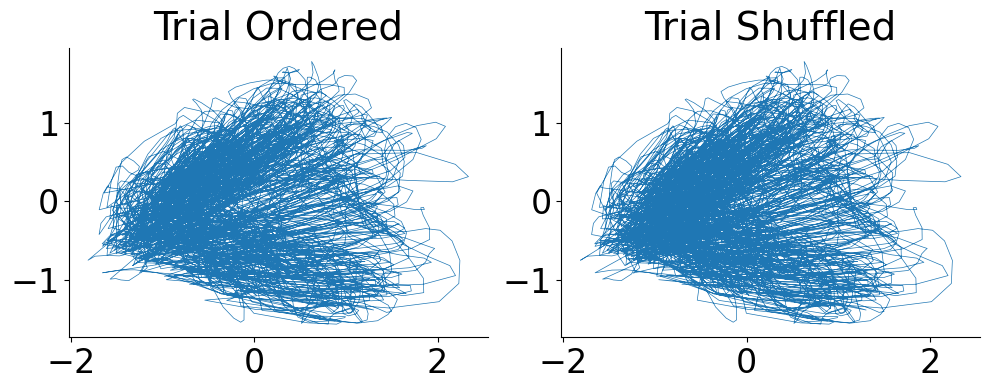

In [266]:
# proj_data_ordered.shape, proj_data_shuffled.shape
pca_ordered = PCA(svd_solver='full').fit(ordered_prep_data)
pca_shuffled = PCA(svd_solver='full').fit(shuffled_prep_data)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(pca_ordered.transform(ordered_prep_data)[:,0], pca_ordered.transform(ordered_prep_data)[:,1], linewidth=0.5)
ax[1].plot(pca_shuffled.transform(shuffled_prep_data)[:,0], pca_shuffled.transform(shuffled_prep_data)[:,1], linewidth=0.5)
ax[0].set_title('Trial Ordered'), ax[1].set_title('Trial Shuffled')
fig.tight_layout()
plt.show()

In [267]:
np.max(np.abs(pca_ordered.components_ - pca_shuffled.components_))

2.6163793354072595e-13

In [268]:
# data projected onto PC1 should have all the same data points
ordered_pc1_argsort = np.argsort(pca_ordered.transform(ordered_prep_data)[:,1])
shuffled_pc1_argsort = np.argsort(pca_shuffled.transform(shuffled_prep_data)[:,1])
np.max(np.abs(pca_ordered.transform(ordered_prep_data)[ordered_pc1_argsort,1] - pca_shuffled.transform(shuffled_prep_data)[shuffled_pc1_argsort,1]))

5.10702591327572e-15

In [269]:
Q_ordered, r_ordered, _ = qr(pca_ordered.transform(ordered_prep_data), mode='economic', pivoting=True, check_finite=True)
Q_shuffled, r_shuffled, _ = qr(pca_shuffled.transform(shuffled_prep_data), mode='economic', pivoting=True, check_finite=True)

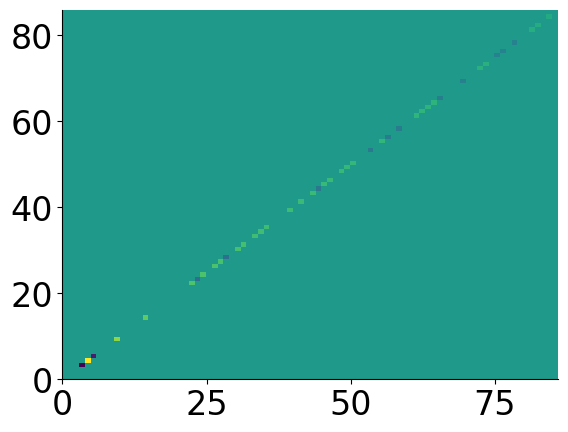

In [270]:
plt.pcolor(r_ordered - r_shuffled)

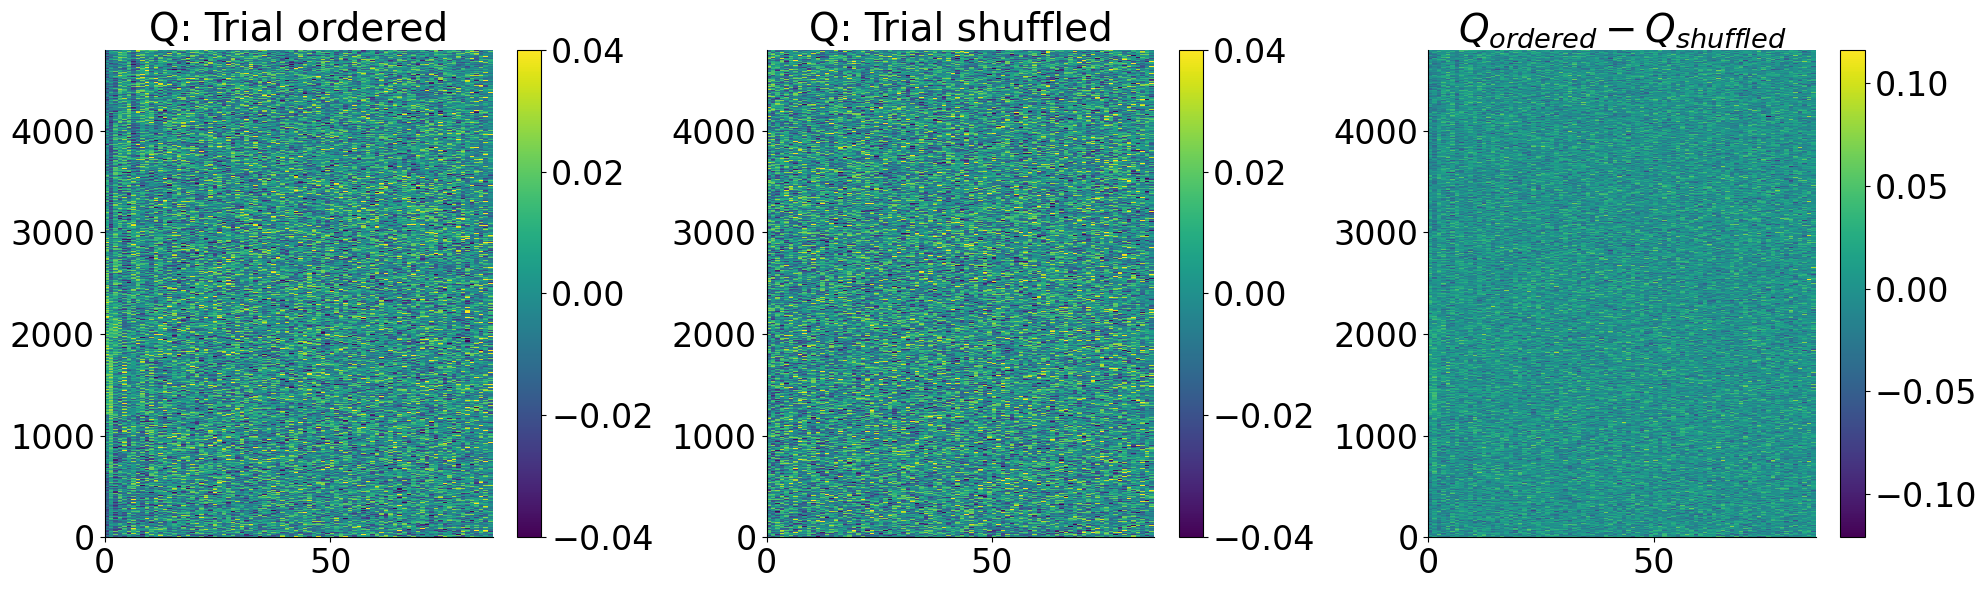

In [274]:
fig, ax = plt.subplots(1,3, figsize=(20,6))
im0 = ax[0].pcolor(Q_ordered, vmin=-0.04, vmax=0.04)
ax[0].set_title('Q: Trial ordered')
cb = plt.colorbar(im0)

im1 = ax[1].pcolor(Q_shuffled, vmin=-0.04, vmax=0.04)
ax[1].set_title('Q: Trial shuffled')
cb = plt.colorbar(im1)

im2 = ax[2].pcolor(Q_ordered - Q_shuffled)
ax[2].set_title('$Q_{ordered} - Q_{shuffled}$')
cb = plt.colorbar(im2)

# ax[0].set_aspect('equal'), ax[1].set_aspect('equal'), ax[2].set_aspect('equal')
fig.tight_layout()
plt.show()

### PC projection alignment

In [247]:
ccs = np.zeros((nrecs, nrecs, npcs))*np.nan
cca_proj_data = np.zeros((nrecs, nrecs, proj_data[0].shape[0], npcs))*np.nan
ccs_trd = np.zeros((nrecs, nrecs, 2))*np.nan

# np_acc_arg_sort = np.argsort(max_np_decoding[align_events[-1]])
# np_acc_arg_sort = np.arange(nrecs)
for irec in tqdm(range(nrecs)):
    for irec2 in range(nrecs):
        # if proj_data[irec].shape[1] >= 5 and proj_data[irec2].shape[1] >=5:
        if len(proj_trd_data[irec]) > 0 and len(proj_trd_data[irec2]) > 0:
            if proj_data[irec].shape[1] >= npcs and proj_data[irec2].shape[1] >= npcs:
                # for ipc in range(npcs):
                # Ma, Mb, S = compute_CCA(proj_data[irec][:ntime,:npcs], proj_data[irec2][:ntime,:npcs])
                Ma, Mb, S, U, _ = canoncorr_gallego(proj_data[irec][:,:npcs], proj_data[irec2][:,:npcs], fullReturn=True)
                ccs[irec,irec2,:] =S[:npcs]
                cca_proj_data[irec,irec2,:,:] = proj_data[irec][:,:npcs] @ Ma
                # cca_proj_data[irec,irec2,:,:] = proj_data[irec2][:ntime,:npcs] @ Mb @ np.linalg.pinv(Ma) # Only project onto the first npc planes
                
                # cca_proj_data[irec,irec2,:,:] = proj_data[irec2][:,:npcs] @ Mb[:npcs,:][:,:npcs] @ np.linalg.pinv(Ma)[:npcs,:][:,:npcs] # Only project onto the first npc planes

                # if irec == 0 and irec2 == 1:
                #     saved_Ma = Ma
                #     saved_Mb = Mb
                
                Ma_trd, Mb_trd, S_trd = compute_CCA(proj_trd_data[irec][:,1:], proj_trd_data[irec2][:,1:])
                ccs_trd[irec,irec2,:] =S_trd [:2]

  0%|          | 0/2 [00:00<?, ?it/s]

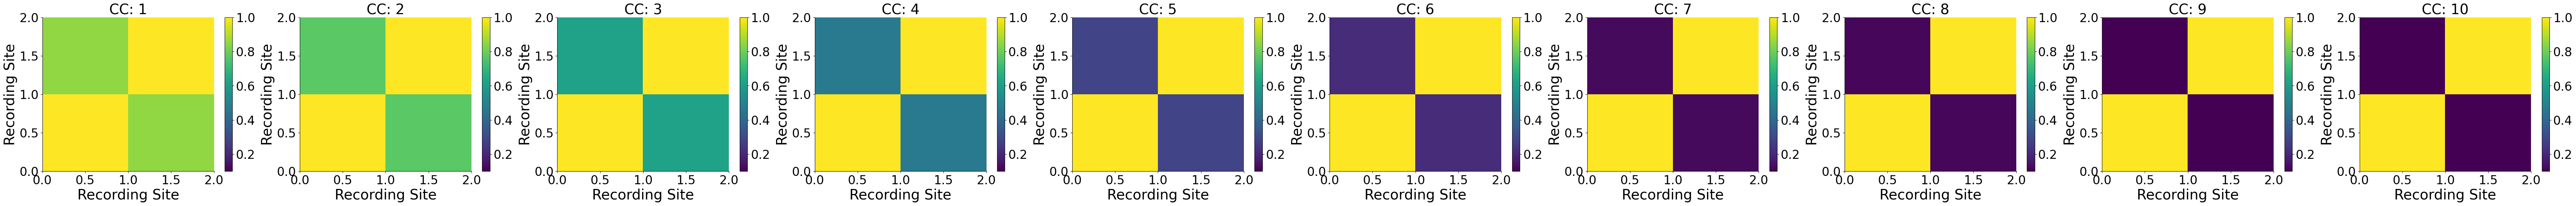

In [248]:
fig, ax = plt.subplots(1, npcs, figsize=(npcs*9, 5.5))
for ipc in range(npcs):
    im = ax[ipc].pcolor(ccs[:,:,ipc], vmin=0.1, vmax=1)
    cb = plt.colorbar(im)
    # ax[ipc].set_xticks(np.arange(nrecs)+0.5, recording_site)
    # ax[ipc].set_yticks(np.arange(nrecs)+0.5, recording_site)
    ax[ipc].set(xlabel='Recording Site', ylabel='Recording Site', title=f"CC: {ipc+1}")

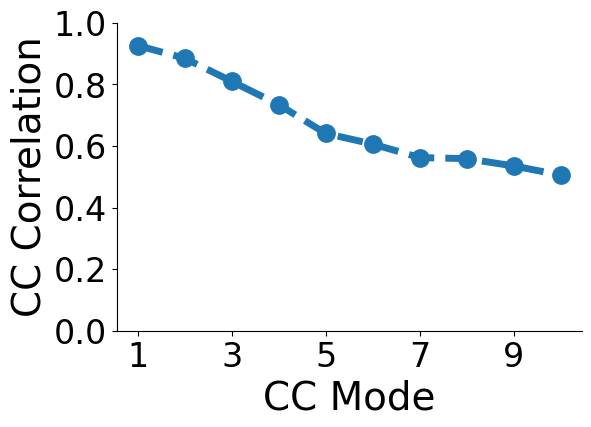

In [249]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(np.arange(npcs)+1, np.nanmean(ccs, axis=(0,1)), '--.', markersize=25)
ax.set(xlabel='CC Mode', ylabel='CC Correlation', ylim=(0,1))
ax.set_xticks(np.arange(0,npcs,2)+1)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

### TRD projection alignment

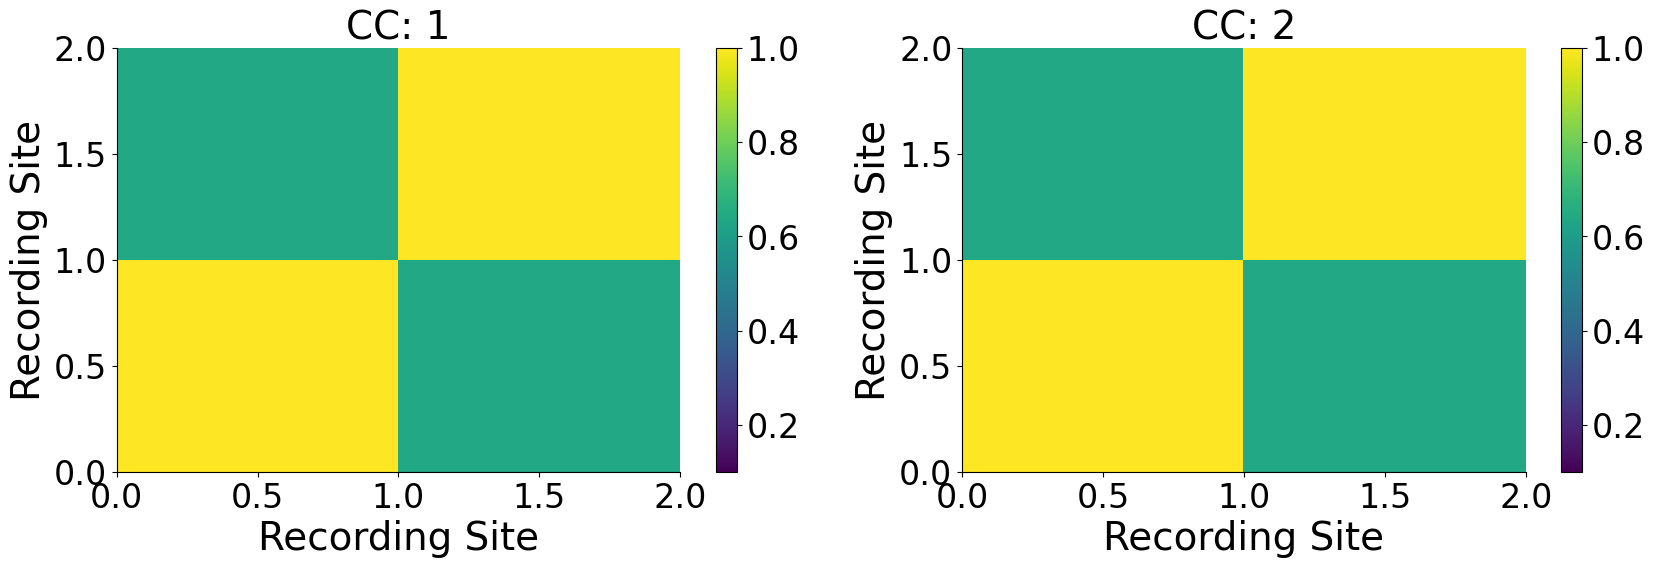

In [250]:
ntrd = 2
fig, ax = plt.subplots(1, ntrd, figsize=(ntrd*10, 5.5))
for ipc in range(ntrd):
    im = ax[ipc].pcolor(ccs_trd[:,:,ipc], vmin=0.1, vmax=1)
    cb = plt.colorbar(im)
    # ax[ipc].set_xticks(np.arange(nrecs)+0.5, recording_site)
    # ax[ipc].set_yticks(np.arange(nrecs)+0.5, recording_site)
    ax[ipc].set(xlabel='Recording Site', ylabel='Recording Site', title=f"CC: {ipc+1}")

In [251]:
# Plot subspace angle for each site:
trd_subspace_angle = np.zeros(nrecs)*np.nan
for irec in range(nrecs):
    if len(trd_subspace[irec]) > 0:
        if trd_subspace[irec].shape[0] > npcs:
            trd_subspace_angle[irec] = np.rad2deg(scipy.linalg.subspace_angles(trd_subspace[irec][:,0][:,None], trd_subspace[irec][:,1][:,None]))

/tmp/ipykernel_646466/956785186.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trd_subspace_angle[irec] = np.rad2deg(scipy.linalg.subspace_angles(trd_subspace[irec][:,0][:,None], trd_subspace[irec][:,1][:,None]))


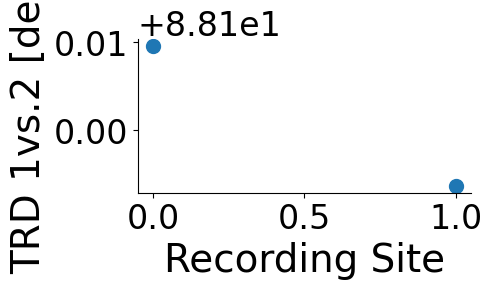

In [252]:

# np_acc_arg_sort = np.argsort(np.array(max_np_decoding[align_event]))
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot(np.arange(nrecs), trd_subspace_angle,'.', markersize=20)
ax.set(xlabel='Recording Site', ylabel='TRD 1vs.2 [deg]')

fig.tight_layout()

## Decoding in different PCs

### Linear regression decoder

#### Test with data from paper

In [253]:
# Load test data from paper analysis
chewie_neural = np.load("/media/moor-data/test/Safaie et al 2023 data/intermediete_data/chewie_neural.npy")
mihili_neural = np.load("/media/moor-data/test/Safaie et al 2023 data/intermediete_data/mihili_neural.npy")
chewie_vel = np.load("/media/moor-data/test/Safaie et al 2023 data/intermediete_data/chewie_vel.npy")
mihili_vel = np.load("/media/moor-data/test/Safaie et al 2023 data/intermediete_data/mihili_vel.npy")

temp_cvel = []
temp_mvel = []
for itrial in range(chewie_vel.shape[0]):
    temp_cvel.extend(chewie_vel[itrial,:,:])
    temp_mvel.extend(mihili_vel[itrial,:,:])
    
chewie_vel = np.array(temp_cvel)
mihili_vel = np.array(temp_mvel)

(2016, 40) (2016, 40) (2016, 2) (2016, 2)
0.5357842964547266 0.7799059535910827


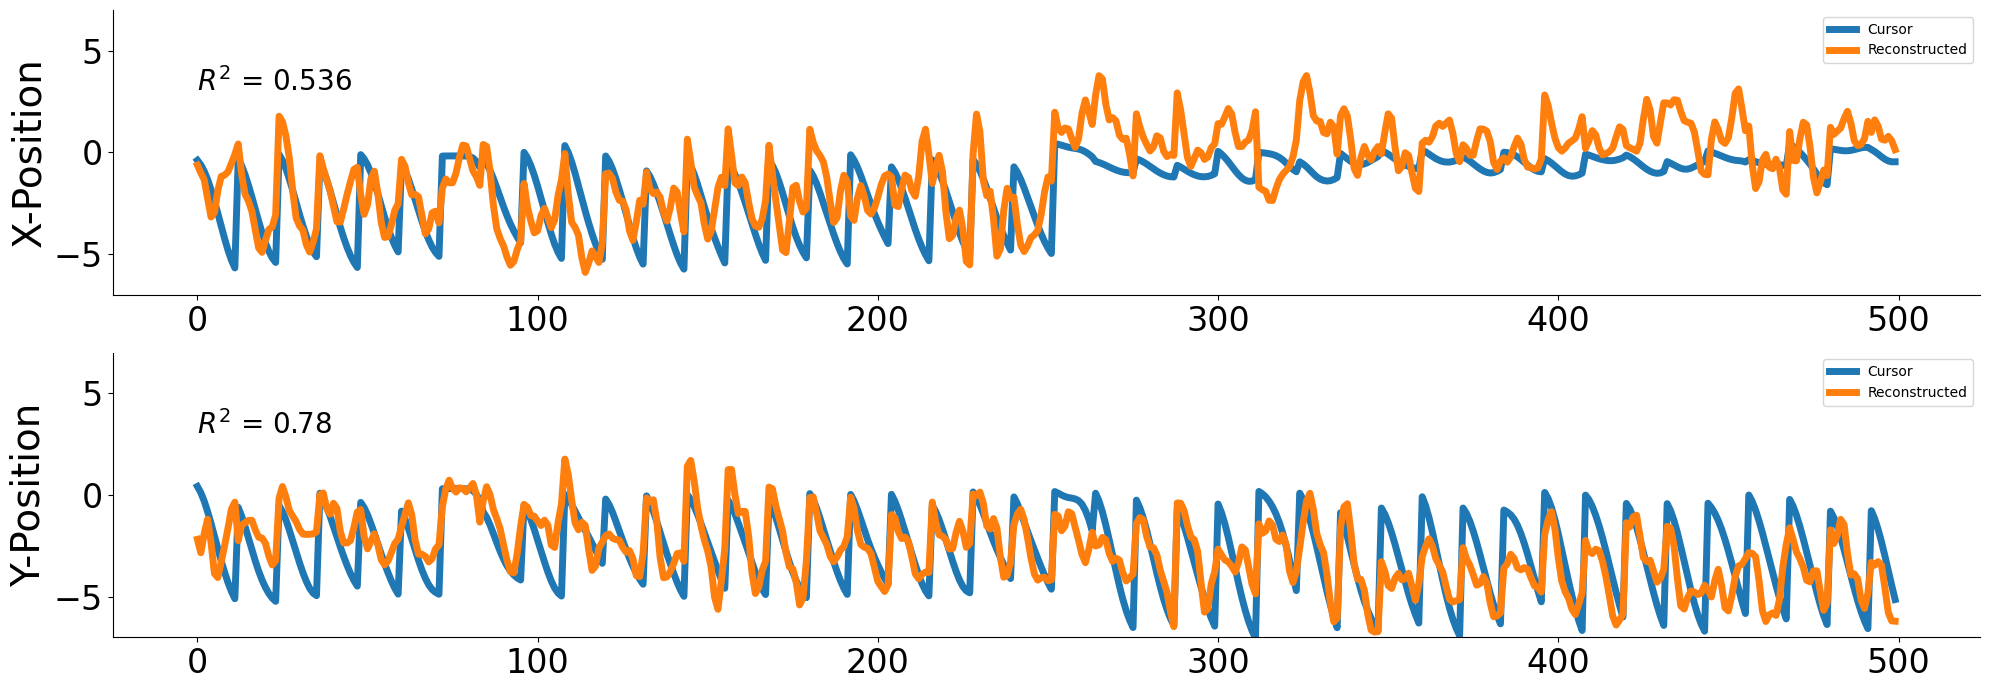

In [254]:
print(chewie_neural.shape, mihili_neural.shape, chewie_vel.shape, mihili_vel.shape)
nlags = 0
Ma, Mb, S, U, V = canoncorr_gallego(chewie_neural, mihili_neural, fullReturn=True)
train_subspace, kin_recon = weiner_filter(U, chewie_vel, regularization=None, alpha=.00001, lags=nlags, fit_intercept=False)
    
aligned_dynamics = make_lagged_matrix(V, nlags) @ train_subspace
r2x = sklearn.metrics.r2_score(mihili_vel[nlags:,0], aligned_dynamics[:,0])
r2y = sklearn.metrics.r2_score(mihili_vel[nlags:,1], aligned_dynamics[:,1])
print(r2x, r2y)

# Plot training data reconstruction to ensure decoding function works
stop_idx=500
fig, ax = plt.subplots(2,1,figsize=(20,7))
ax[0].plot(mihili_vel[nlags:stop_idx,0])
ax[0].plot(aligned_dynamics[:stop_idx,0])
ax[0].legend(['Cursor', 'Reconstructed'])
ax[0].set(ylabel='X-Position',ylim=(-7, 7))
ax[0].annotate(f"$R^2$ = {np.round(r2x,3)}", (0, 3), fontsize=20)

ax[1].plot(mihili_vel[nlags:stop_idx,1])
ax[1].plot(aligned_dynamics[:stop_idx,1])
ax[1].legend(['Cursor', 'Reconstructed'])
ax[1].set(ylabel='Y-Position',ylim=(-7, 7))
ax[1].annotate(f"$R^2$ = {np.round(r2y,3)}", (0, 3), fontsize=20)
fig.tight_layout()
plt.show()


#### Apply their data with my preprocessing

In [255]:
# Use data projected into same-day PCs to train
within_day_decoding = np.zeros((nrecs))*np.nan
within_day_decoding_tidx1 = np.zeros((nrecs))*np.nan
within_day_decoding_tidx2 = np.zeros((nrecs))*np.nan
nlags = 4
cca_decoding_kin_data = velo_data_all
# Train on day 1
for irec in range(nrecs):
    subspace, kin_recon = weiner_filter(proj_data[irec][:,:npcs], cca_decoding_kin_data[irec][:,:], regularization=None, alpha=10000, lags=nlags, fit_intercept=False)
    # r2x = sklearn.metrics.r2_score(cca_decoding_kin_data[irec][nlags:,0], kin_recon[:,1])
    # r2y = sklearn.metrics.r2_score(cca_decoding_kin_data[irec][nlags:,1], kin_recon[:,2])
    r2x = sklearn.metrics.r2_score(cca_decoding_kin_data[irec][nlags:,0], (make_lagged_matrix(proj_data[irec][:,:npcs], nlags)@subspace)[:,0])
    r2y = sklearn.metrics.r2_score(cca_decoding_kin_data[irec][nlags:,1], (make_lagged_matrix(proj_data[irec][:,:npcs], nlags)@subspace)[:,1])
    within_day_decoding[irec] = np.mean([r2x, r2y])
    
    # Compute for split data - first half
    subspace, kin_recon = weiner_filter(proj_data[irec][tidx1,:npcs], cca_decoding_kin_data[irec][tidx1,:], regularization=None, alpha=10000, lags=nlags, fit_intercept=False)
    r2xtidx1 = sklearn.metrics.r2_score(cca_decoding_kin_data[irec][tidx1,0][nlags:], kin_recon[:,0])
    r2ytidx1 = sklearn.metrics.r2_score(cca_decoding_kin_data[irec][tidx1,1][nlags:], kin_recon[:,1])
    within_day_decoding_tidx1[irec] = np.mean([r2xtidx1, r2ytidx1])

    # Compute for split data - second half
    subspace, kin_recon = weiner_filter(proj_data[irec][tidx2,:npcs], cca_decoding_kin_data[irec][tidx2,:], regularization=None, alpha=10000, lags=nlags, fit_intercept=False)
    r2xtidx2 = sklearn.metrics.r2_score(cca_decoding_kin_data[irec][tidx2,0][nlags:], kin_recon[:,0])
    r2ytidx2 = sklearn.metrics.r2_score(cca_decoding_kin_data[irec][tidx2,1][nlags:], kin_recon[:,1])
    within_day_decoding_tidx2[irec] = np.mean([r2xtidx2, r2ytidx2])


    print(f"{irec} Site: {irec}", np.round(r2x, 3), np.round(r2y,3), np.round(np.mean([r2x, r2y]),3),  np.round(np.mean([r2xtidx1, r2ytidx1]),3),  np.round(np.mean([r2xtidx2, r2ytidx2]),3))

0 Site: 0 0.693 0.683 0.688 0.367 0.304
1 Site: 1 0.455 0.712 0.584 0.118 0.252


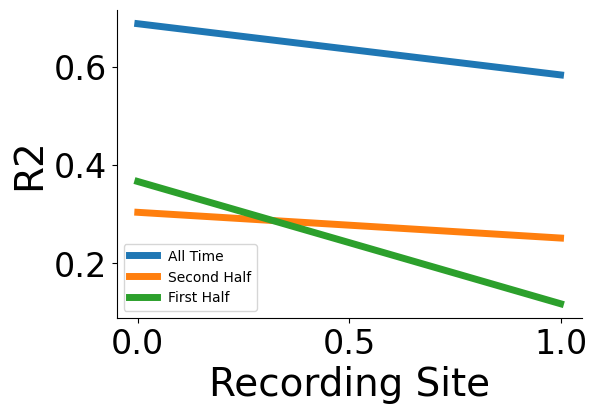

In [256]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(within_day_decoding, label='All Time')
ax.plot(within_day_decoding_tidx2, label='Second Half')
ax.plot(within_day_decoding_tidx1, label='First Half')

ax.set(xlabel='Recording Site', ylabel='R2')
ax.legend()
plt.show()

In [257]:
# Test CCA decoding/transformation on data from the same day split in time with linear regression
# Decode using CCA transformation 
same_day_align_R = np.zeros((nrecs, npcs))*np.nan
same_day_aligned_decoding = np.zeros((nrecs))*np.nan
same_day_aligned_dynamics = []
nlags=4
for irec in range(nrecs):
    La = proj_data_tidx1[irec][:,:npcs]
    Lb = proj_data_tidx2[irec][:,:npcs]
    ntime_split = proj_data[irec].shape[0]//2

    # Align data
    # Ma, Mb, S = compute_CCA(La, Lb)
    Ma, Mb, S, U, V = canoncorr_gallego(La, Lb, fullReturn=True)
    same_day_align_R[irec,:npcs] =S[:npcs]
    # same_day_align_proj_data = Lb @ Mb @ np.linalg.pinv(Ma) # Only project onto the first npc planes
    # same_day_align_proj_data = Lb @ Mb # Only project onto the first npc planes
    # same_day_align_proj_data = La @ Ma @ np.linalg.pinv(Mb) # Only project onto the first npc planes

   # Train decoder using baseline site dynamics projected onto the shared dimensions
    same_day_aligned_subspace, kin_recon = weiner_filter(U, cca_decoding_kin_data[irec][tidx1,:], regularization=None, alpha=.00001, lags=nlags, fit_intercept=False)

    # Test decoder using new site dynamics projected onto baseline laten tdynamics
    aligned_dynamics = make_lagged_matrix(V, nlags) @ same_day_aligned_subspace
    # aligned_dynamics = V @ same_day_aligned_subspace
    same_day_aligned_dynamics.append(aligned_dynamics)

    # Compute R2 metrics
    r2x = sklearn.metrics.r2_score(cca_decoding_kin_data[irec][tidx2[nlags:],0], aligned_dynamics[:,0])
    r2y = sklearn.metrics.r2_score(cca_decoding_kin_data[irec][tidx2[nlags:],1], aligned_dynamics[:,1])
    print(r2x, r2y)
    same_day_aligned_decoding[irec] = np.mean([r2x, r2y])


-1.8884654584562872 -3.122714639704175
-1.344846804438653 -2.052196009122295


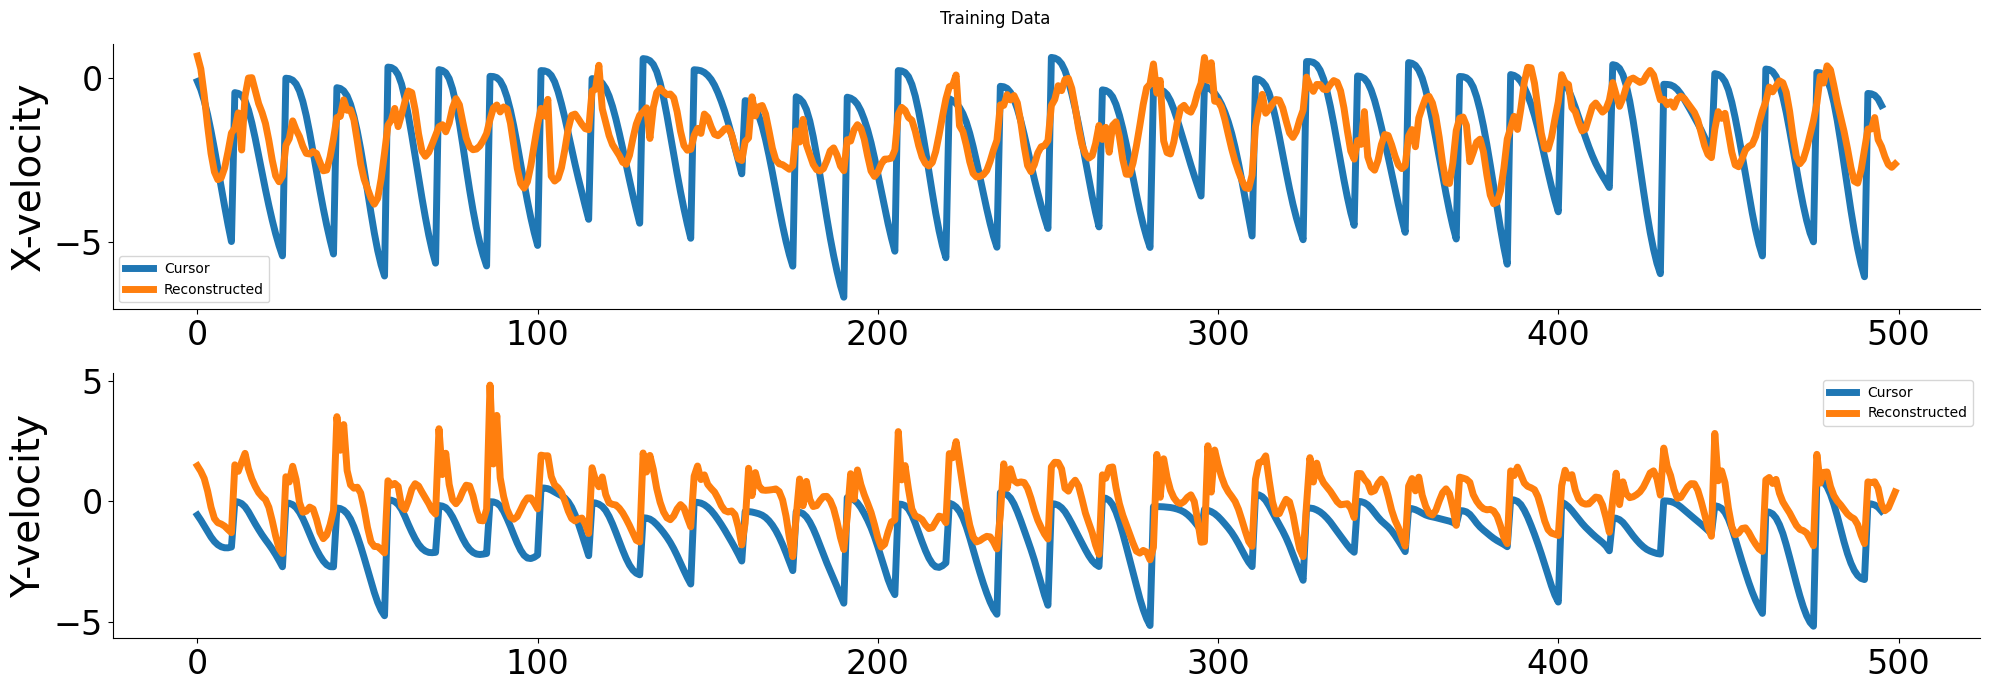

In [258]:
# Plot training data reconstruction to ensure decoding function works
stop_idx=500
fig, ax = plt.subplots(2,1,figsize=(20,7))
ax[0].plot(cca_decoding_kin_data[irec][tidx1[nlags:stop_idx],0])
ax[0].plot(kin_recon[:stop_idx,0])
ax[0].legend(['Cursor', 'Reconstructed'])
ax[0].set(ylabel='X-velocity')

ax[1].plot(cca_decoding_kin_data[irec][tidx1[nlags:stop_idx],1])
ax[1].plot(kin_recon[:stop_idx,1])
ax[1].legend(['Cursor', 'Reconstructed'])
ax[1].set(ylabel='Y-velocity')
plt.suptitle('Training Data')
fig.tight_layout()
plt.show()

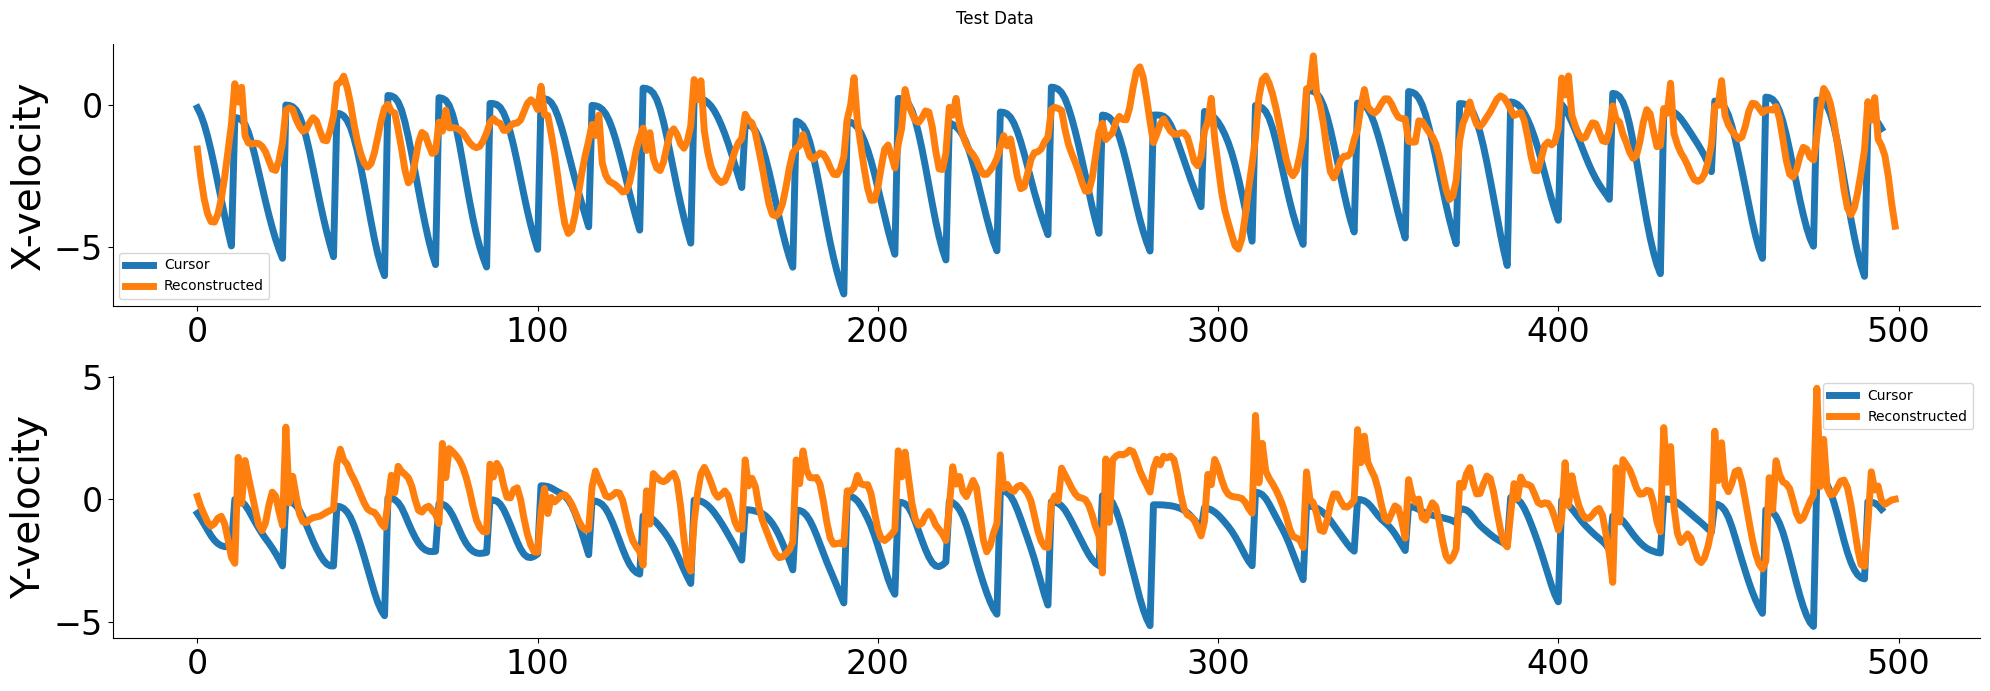

In [259]:
stop_idx = 500

fig, ax = plt.subplots(2,1,figsize=(20,7))
ax[0].plot(cca_decoding_kin_data[irec][tidx1[nlags:stop_idx],0])
ax[0].plot(same_day_aligned_dynamics[irec][:stop_idx,0])
ax[0].legend(['Cursor', 'Reconstructed'])
ax[0].set(ylabel='X-velocity')

ax[1].plot(cca_decoding_kin_data[irec][tidx1[nlags:stop_idx],1])
ax[1].plot(same_day_aligned_dynamics[irec][:stop_idx,1])
ax[1].legend(['Cursor', 'Reconstructed'])
ax[1].set(ylabel='Y-velocity')
plt.suptitle('Test Data')
fig.tight_layout()
plt.show()

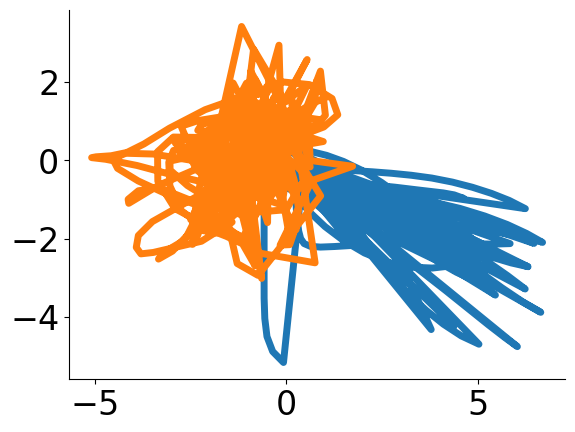

In [260]:
itrial = 0
ntrials = 8
irec = -1
trial_idx = np.arange((itrial*50),((itrial+ntrials)*50))
fig, ax = plt.subplots(1,1)
ax.plot(cca_decoding_kin_data[irec][tidx2[trial_idx],0], cca_decoding_kin_data[irec][trial_idx,1])
ax.plot(same_day_aligned_dynamics[irec][trial_idx,-2], same_day_aligned_dynamics[irec][trial_idx,-1])
plt.show()

0.6926533227178959 0.6833283812785494


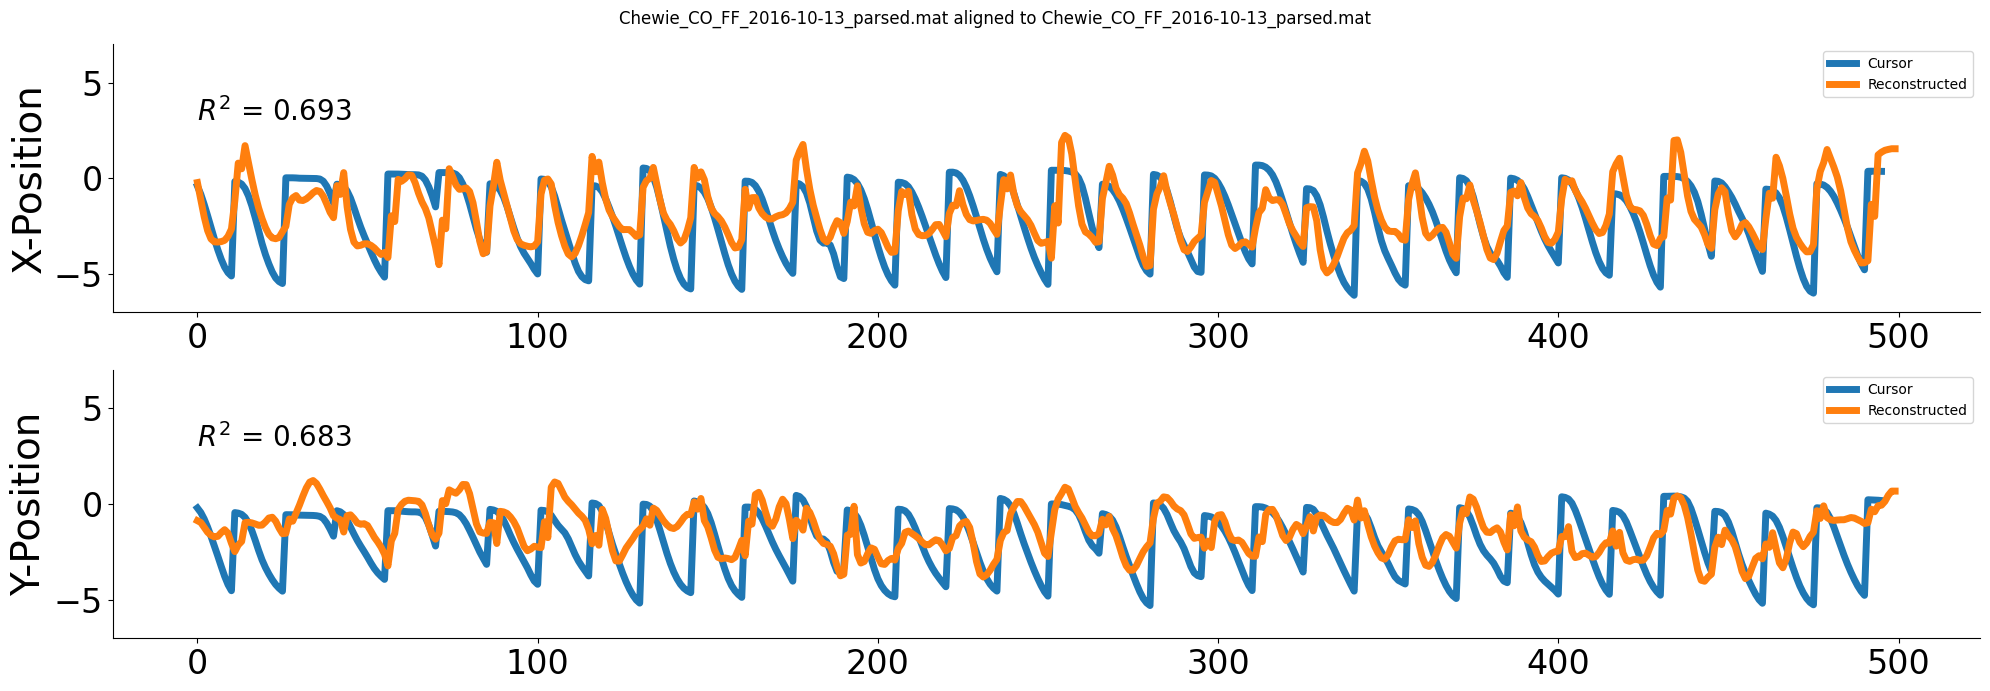

0.15007707301177764 0.588488311577575


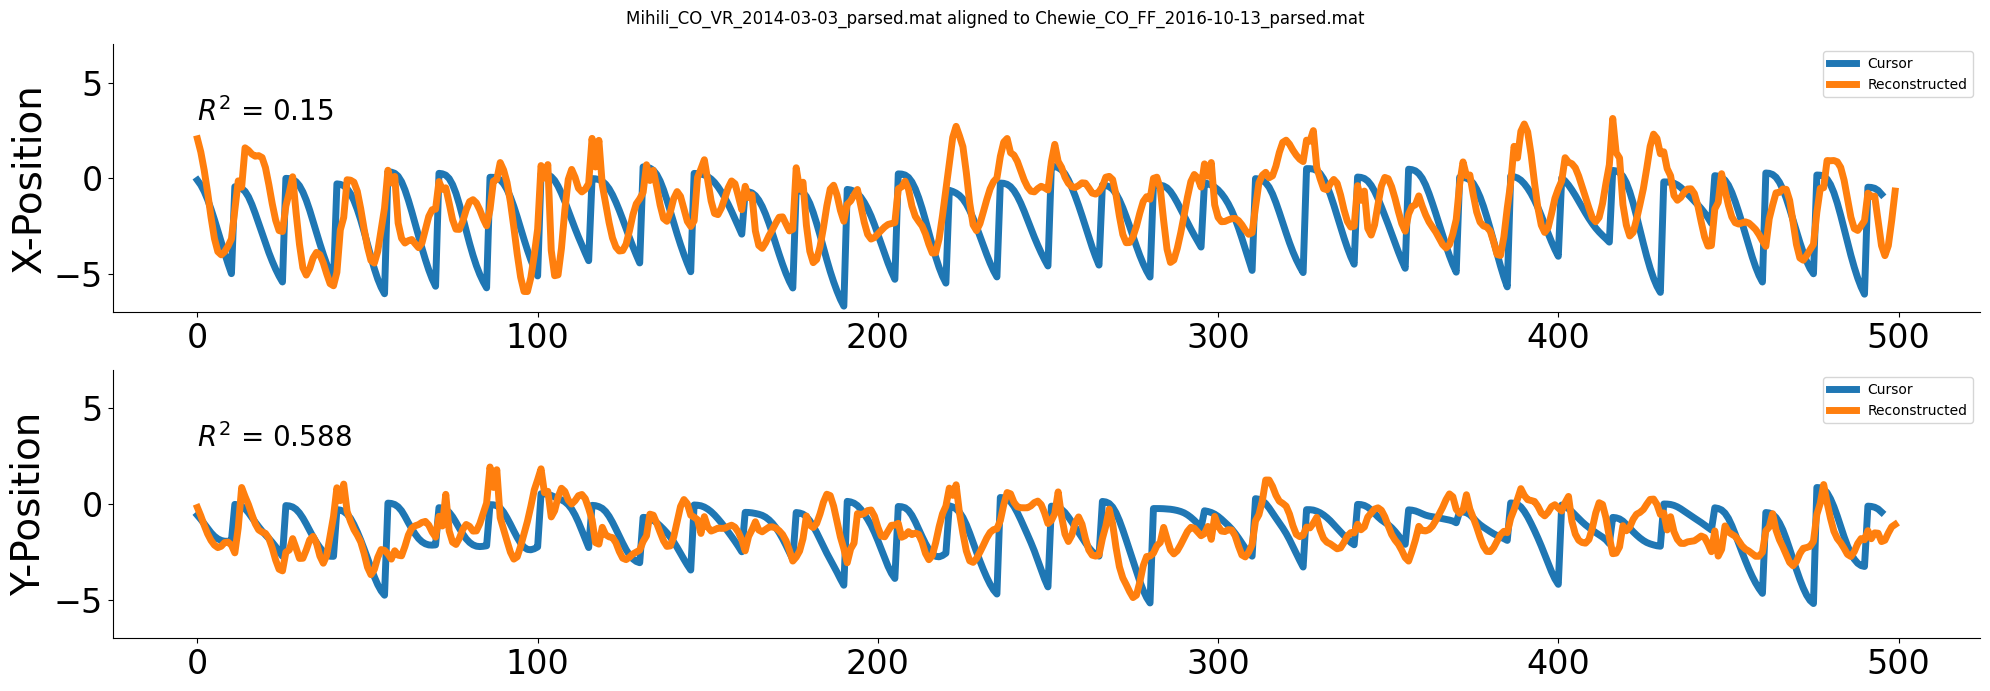

0.5021569040264178 0.5646490547248514


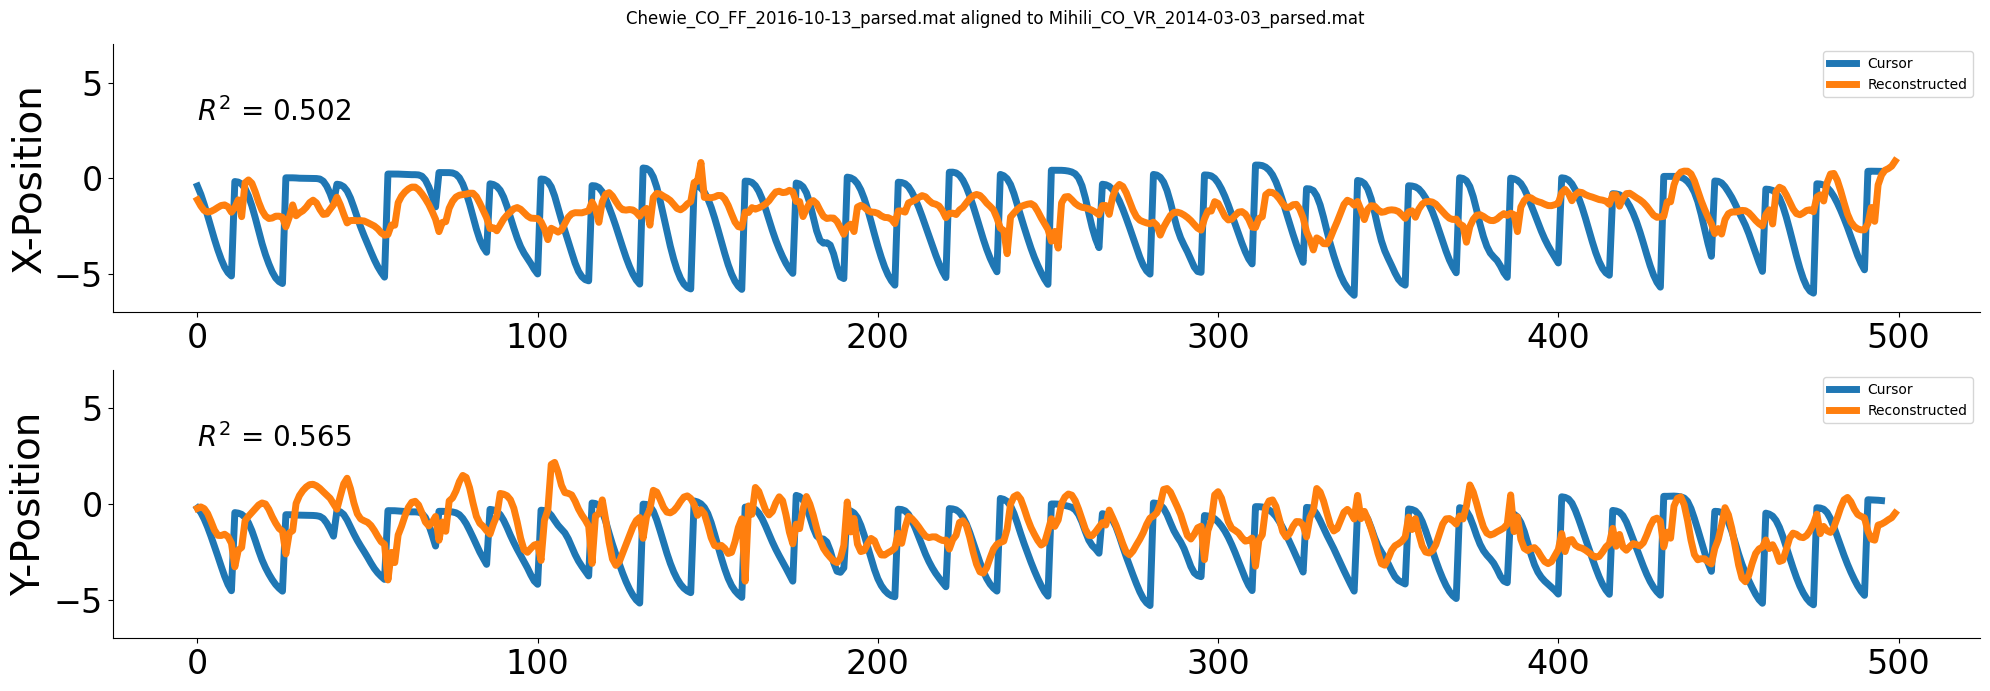

0.4553720995148042 0.7122308986470154


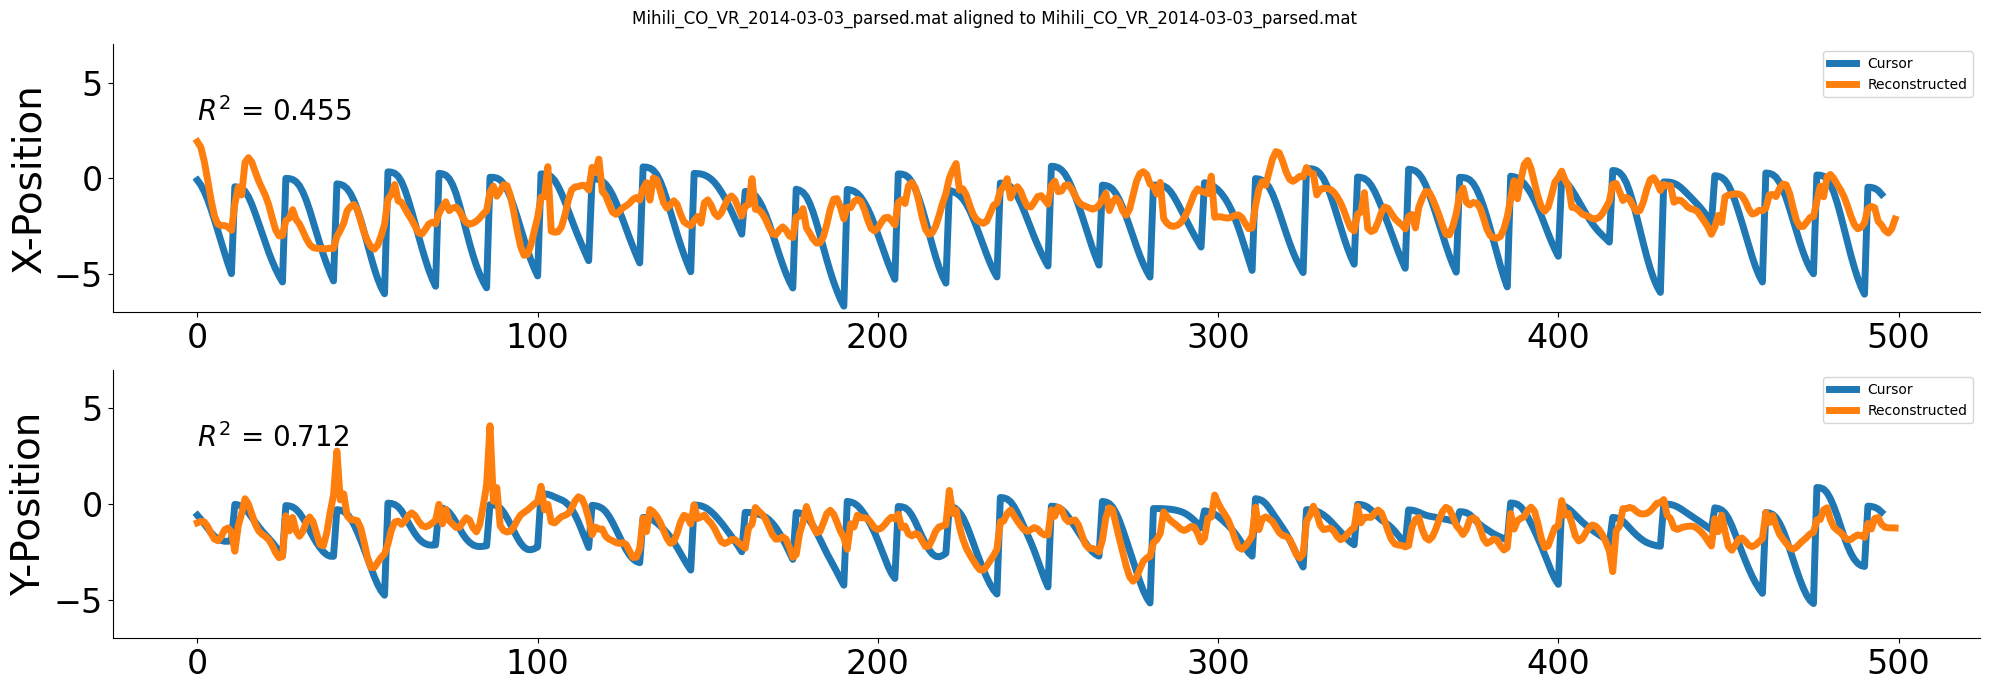

In [261]:
# Decode using CCA transformation 
across_day_decoding = np.zeros((nrecs, nrecs))*np.nan
for baseline_rec in range(nrecs):
    for new_rec in range(nrecs):
        La = proj_data[baseline_rec][:,:npcs]
        Lb = proj_data[new_rec][:,:npcs]
        
        Ma, Mb, S, U, V = canoncorr_gallego(La, Lb, fullReturn=True)
        
        # Train decoder using baseline site dynamics projected onto the shared dimensions
        baseline_aligned_subspace, kin_recon = weiner_filter(U, cca_decoding_kin_data[baseline_rec], regularization=None, alpha=.00001, lags=nlags, fit_intercept=False)

        # Test decoder using new site dynamics projected onto the shared dimensions
        aligned_dynamics = make_lagged_matrix(V, nlags) @ baseline_aligned_subspace

        # Compute R2 metrics
        # print(sklearn.metrics.r2_score(cca_decoding_kin_data[baseline_rec][nlags:,0], kin_recon[:,0]))
        r2x = sklearn.metrics.r2_score(cca_decoding_kin_data[new_rec][nlags:,0], aligned_dynamics[:,0])
        r2y = sklearn.metrics.r2_score(cca_decoding_kin_data[new_rec][nlags:,1], aligned_dynamics[:,1])
        print(r2x, r2y)
        across_day_decoding[baseline_rec, new_rec] = np.mean([r2x, r2y])
        
        stop_idx=500
        fig, ax = plt.subplots(2,1,figsize=(20,7))
        ax[0].plot(cca_decoding_kin_data[new_rec][nlags:stop_idx,0])
        ax[0].plot(aligned_dynamics[:stop_idx,0])
        ax[0].legend(['Cursor', 'Reconstructed'])
        ax[0].set(ylabel='X-Position',ylim=(-7, 7))
        ax[0].annotate(f"$R^2$ = {np.round(r2x,3)}", (0, 3), fontsize=20)

        ax[1].plot(cca_decoding_kin_data[new_rec][nlags:stop_idx,1])
        ax[1].plot(aligned_dynamics[:stop_idx,1])
        ax[1].legend(['Cursor', 'Reconstructed'])
        ax[1].set(ylabel='Y-Position',ylim=(-7, 7))
        ax[1].annotate(f"$R^2$ = {np.round(r2y,3)}", (0, 3), fontsize=20)
        plt.suptitle(f"{filenames[new_rec]} aligned to {filenames[baseline_rec]}")
        fig.tight_layout()
        plt.show()


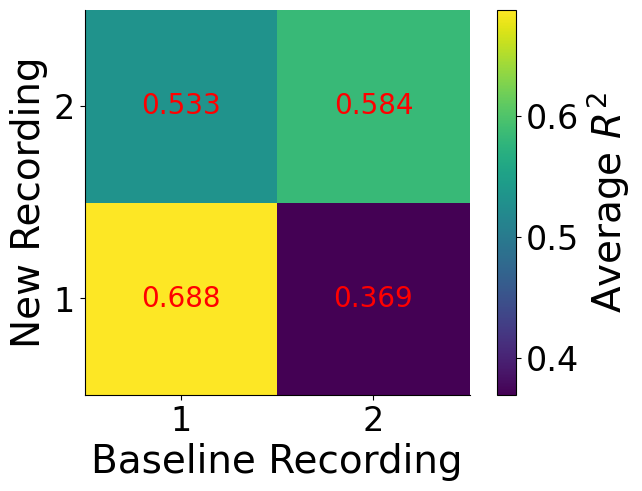

In [262]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
dec_mat = ax.pcolor(across_day_decoding)
ax.set(xlabel='Baseline Recording', ylabel='New Recording')
ax.set_xticks(np.arange(nrecs)+0.5, np.arange(nrecs)+1)
ax.set_yticks(np.arange(nrecs)+0.5, np.arange(nrecs)+1)
for baseline_rec in range(nrecs):
    for new_rec in range(nrecs):
        ax.annotate(f"{np.round(across_day_decoding[new_rec, baseline_rec],3)}", (baseline_rec+0.5, new_rec+0.5), ha='center', va='center', fontsize=20, color='red')
cb = plt.colorbar(dec_mat, label='Average $R^2$')
ax.set_aspect('equal')
plt.show()

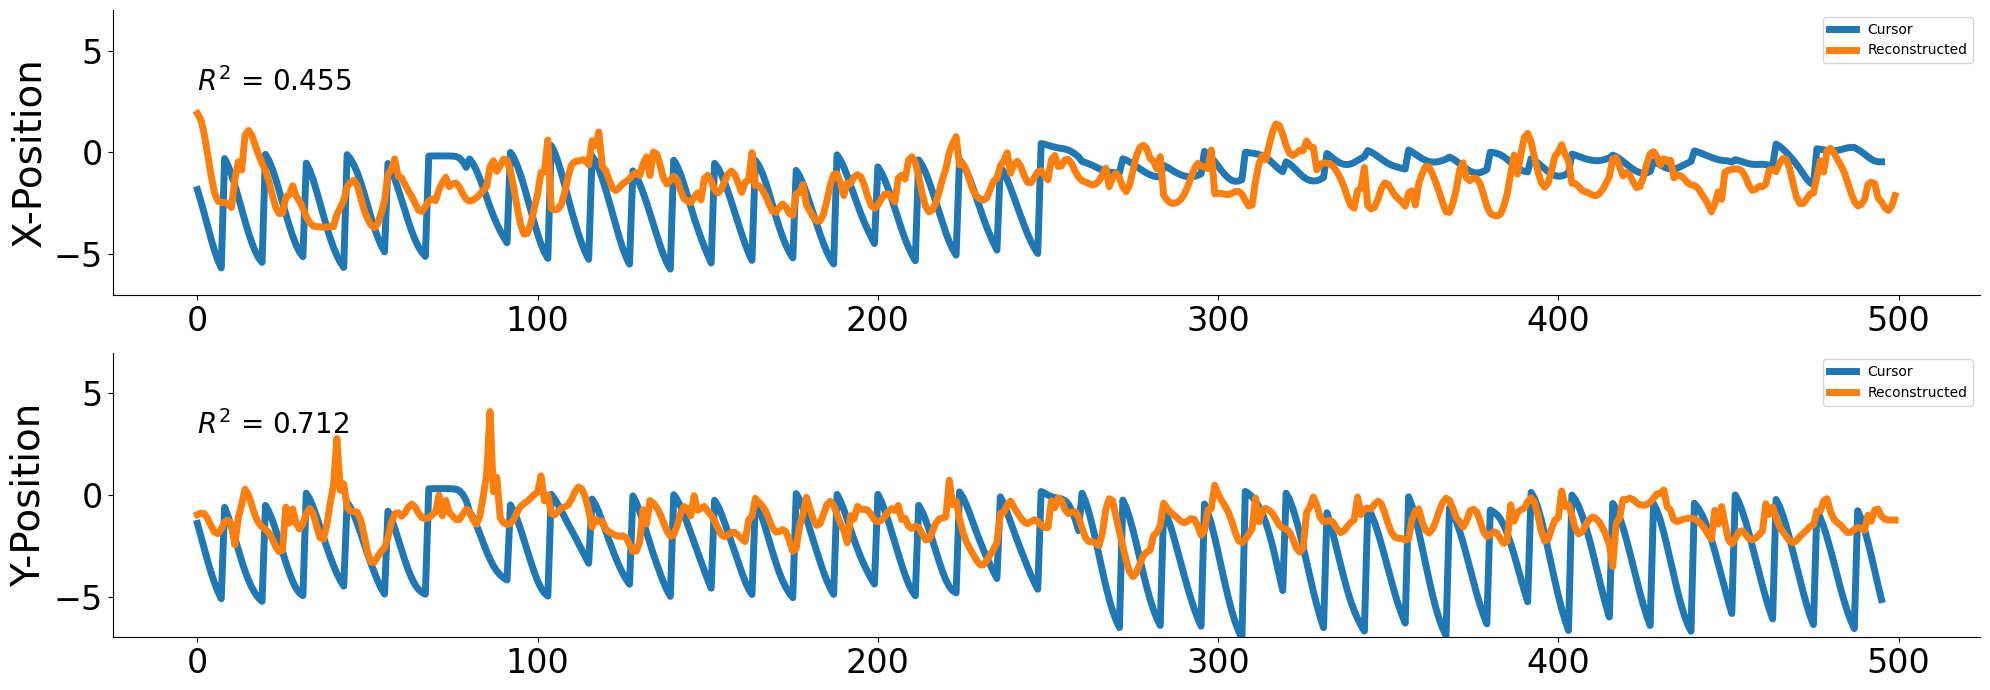

In [263]:
stop_idx=500
fig, ax = plt.subplots(2,1,figsize=(20,7))
ax[0].plot(mihili_vel[nlags:stop_idx,0])
ax[0].plot(aligned_dynamics[:stop_idx,0])
ax[0].legend(['Cursor', 'Reconstructed'])
ax[0].set(ylabel='X-Position',ylim=(-7, 7))
ax[0].annotate(f"$R^2$ = {np.round(r2x,3)}", (0, 3), fontsize=20)

ax[1].plot(mihili_vel[nlags:stop_idx,1])
ax[1].plot(aligned_dynamics[:stop_idx,1])
ax[1].legend(['Cursor', 'Reconstructed'])
ax[1].set(ylabel='Y-Position',ylim=(-7, 7))
ax[1].annotate(f"$R^2$ = {np.round(r2y,3)}", (0, 3), fontsize=20)
fig.tight_layout()
plt.show()


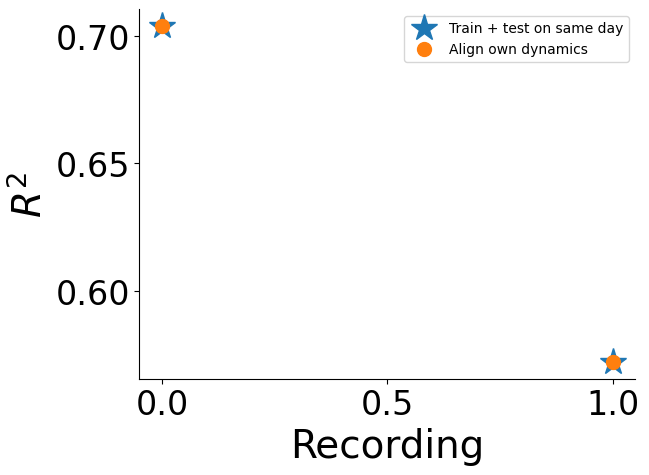

In [30]:
fig, ax = plt.subplots(1,1)
ax.plot(across_day_decoding[np.diag_indices(nrecs)], '*', markersize=20, label='Train + test on same day')
ax.plot(within_day_decoding,'.', markersize=20, label='Align own dynamics')
ax.set(xlabel='Recording', ylabel='$R^2$')
plt.legend()
plt.show()

### LDA Classification decoder

In [31]:
# from sklearn.lda import LDA
import sklearn
def lagged_lda_function(input_data, targets, nlags):
    if nlags > 0:
        data = make_lagged_matrix(input_data, nlags)
    else:
        data = input_data

    # lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
    lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
    lda.fit(data,targets[nlags:])
    
    return lda, lda.score(data, targets[nlags:])
    

In [32]:
# Use data projected into same-day PCs to train
within_day_decoding_lda = np.zeros((nrecs))*np.nan
within_day_decoding_tidx1_lda = np.zeros((nrecs))*np.nan
within_day_decoding_tidx2_lda = np.zeros((nrecs))*np.nan
nlags = 0
cca_decoding_kin_data = target_data_all
# Train on day 1
for irec in range(nrecs):
    model, score = lagged_lda_function(proj_data[irec][:,:npcs], np.rad2deg(cca_decoding_kin_data[irec]), nlags)
    within_day_decoding_lda[irec] = score

    # Compute for split data - first half
    model, score = lagged_lda_function(proj_data[irec][tidx1,:npcs], np.rad2deg(cca_decoding_kin_data[irec][tidx1]),nlags)
    within_day_decoding_tidx1_lda[irec] = score

    # Compute for split data - second half
    model, score = lagged_lda_function(proj_data[irec][tidx2,:npcs], np.rad2deg(cca_decoding_kin_data[irec][tidx2]),nlags)
    within_day_decoding_tidx2_lda[irec] = score


/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning

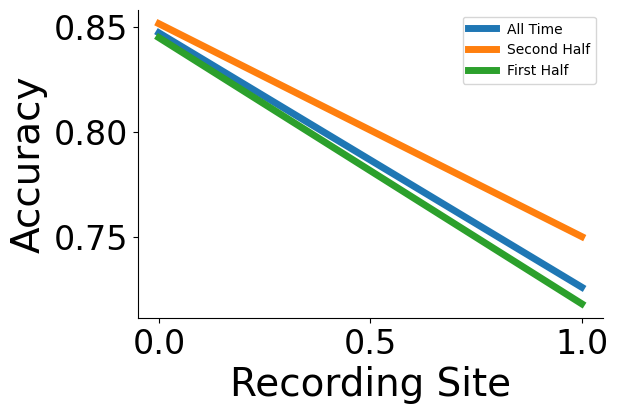

In [33]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(within_day_decoding_lda, label='All Time')
ax.plot(within_day_decoding_tidx2_lda, label='Second Half')
ax.plot(within_day_decoding_tidx1_lda, label='First Half')

ax.set(xlabel='Recording Site', ylabel='Accuracy')
ax.legend()
plt.show()

In [34]:
# Test CCA decoding/transformation on data from the same day split in time with linear regression
# Decode using CCA transformation 
same_day_align_R = np.zeros((nrecs, npcs))*np.nan
same_day_aligned_decoding_lda = np.zeros((nrecs))*np.nan

for irec in range(nrecs):
    if len(proj_data[irec]) > 0:
        if proj_data[irec].shape[1] >= npcs:
            La = proj_data_tidx1[irec][:,:npcs]
            Lb = proj_data_tidx2[irec][:,:npcs]
            ntime_split = proj_data[irec].shape[0]//2
            
            # Align data
            Ma, Mb, S = compute_CCA(La, Lb)
            same_day_align_R[irec,:npcs] =S[:npcs]
            same_day_align_proj_data = Lb @ Mb @ np.linalg.pinv(Ma) # Only project onto the first npc planes
            # same_day_align_proj_data = La @ Ma @ np.linalg.pinv(Mb) # Only project onto the first npc planes

           # Train decoder using baseline site dynamics projected onto the shared dimensions
            model, score = lagged_lda_function(La, np.rad2deg(cca_decoding_kin_data[irec][tidx1]), nlags)

            # Test decoder using new site dynamics projected onto baseline laten tdynamics
            same_day_aligned_decoding_lda[irec] = model.score(make_lagged_matrix(same_day_align_proj_data,nlags), np.rad2deg(cca_decoding_kin_data[irec][tidx2[nlags:]]))

/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


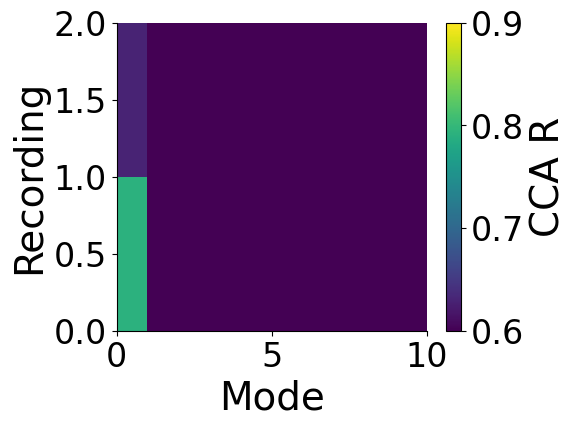

In [35]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
im = ax.pcolor(same_day_align_R, vmin = 0.6, vmax=.9)
plt.colorbar(im, label='CCA R')
ax.set(xlabel='Mode', ylabel='Recording')
plt.show()

In [36]:
within_day_decoding_lda_trial_seperate = np.zeros((nrecs))*np.nan
trial_seperated_proj_data = np.zeros((nt, ntrials_per_target*8, npcs, nrecs))*np.nan
trial_seperated_target = np.zeros(( ntrials_per_target*8, nrecs))*np.nan
for irec in tqdm(range(nrecs)):
    for itrial in range((ntrials_per_target*8)):
        start_idx = itrial*nt
        stop_idx = start_idx+nt
        trial_seperated_proj_data[:,itrial,:,irec] = proj_data[irec][start_idx:stop_idx,:npcs]
        trial_seperated_target[itrial,irec] = target_data_all[irec][start_idx]
        
    lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
    lda.fit(np.mean(trial_seperated_proj_data[:,:,:npcs,irec],axis=0), np.rad2deg(trial_seperated_target[:,irec]))

    within_day_decoding_lda_trial_seperate[irec] = lda.score(np.mean(trial_seperated_proj_data[:,:,:npcs, irec],axis=0), np.rad2deg(trial_seperated_target[:,irec]))

print(within_day_decoding_lda_trial_seperate)

  0%|          | 0/2 [00:00<?, ?it/s]

[0.9875 0.9125]


/tmp/ipykernel_646466/502468305.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trial_seperated_target[itrial,irec] = target_data_all[irec][start_idx]
/tmp/ipykernel_646466/502468305.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trial_seperated_target[itrial,irec] = target_data_all[irec][start_idx]


In [37]:
# Decode using CCA transformation 
nlags = 3
across_day_decoding_lda_trial_seperate = np.zeros((nrecs, nrecs))*np.nan
for baseline_rec in tqdm(range(nrecs)):
    for new_rec in range(nrecs):
        if len(proj_data[baseline_rec]) > 0 and len(proj_data[new_rec])>0:
            if proj_data[baseline_rec].shape[1] >= npcs and proj_data[new_rec].shape[1] >= npcs:

                La = np.mean(trial_seperated_proj_data[:,:,:npcs,baseline_rec],axis=0)
                Lb = np.mean(trial_seperated_proj_data[:,:,:npcs,new_rec],axis=0)
        
                Ma, Mb, S, U, V = canoncorr_gallego(La, Lb, fullReturn=True)
                
                lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
                lda.fit(U, np.rad2deg(trial_seperated_target[:,baseline_rec]))

                across_day_decoding_lda_trial_seperate[baseline_rec, new_rec] = lda.score(V, np.rad2deg(trial_seperated_target[:,new_rec]))
print(across_day_decoding_lda_trial_seperate)

  0%|          | 0/2 [00:00<?, ?it/s]

[[0.9875   0.215625]
 [0.21875  0.9125  ]]


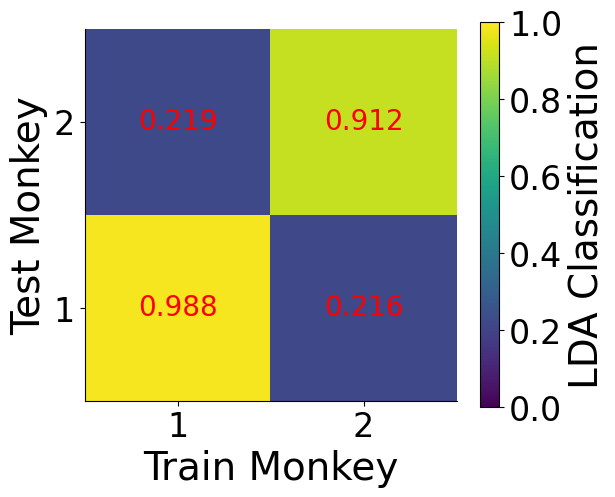

In [38]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
im = ax.pcolor(across_day_decoding_lda_trial_seperate, vmin=0, vmax=1)
ax.set_xticks([0.5, 1.5], [1, 2])
ax.set_yticks([0.5, 1.5], [1, 2])
ax.set(xlabel='Train Monkey', ylabel='Test Monkey')
cb = plt.colorbar(im, label='LDA Classification')
for baseline_rec in range(nrecs):
    for new_rec in range(nrecs):
        ax.annotate(f"{np.round(across_day_decoding_lda_trial_seperate[new_rec, baseline_rec],3)}", (baseline_rec+0.5, new_rec+0.5), ha='center', va='center', fontsize=20, color='red')
ax.set_aspect("equal")